## Forwards Euler

$y_{n+1} = y_n + f(t_n,y_n)h$

Test equation
$y'=-15y$

(-3.0, 5.0)

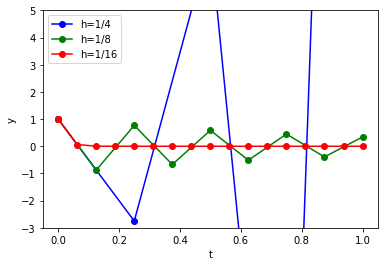

In [37]:
import numpy as np
import matplotlib.pyplot as plt


f = lambda t, y: -15*y
 
def forward_euler(f,h,y0):
    t=np.arange(0,1+h,h)
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(0, len(t)-1):
        y[i+1] = y[i] + h*f(t[i],y[i])
    return t,y
        
fe0 = forward_euler(f,1/4,1)
fe1 = forward_euler(f,1/8,1)
fe2 = forward_euler(f,1/16,1)


plt.plot(fe0[0],fe0[1],color='blue',marker='o',label="h=1/4")
plt.plot(fe1[0],fe1[1],color='green',marker='o',label="h=1/8")
plt.plot(fe2[0],fe2[1],color='red',marker='o',label="h=1/16")


plt.legend()
plt.ylabel("y")
plt.xlabel("t")
plt.ylim(-3,5)

## Backwards Euler with fsolve

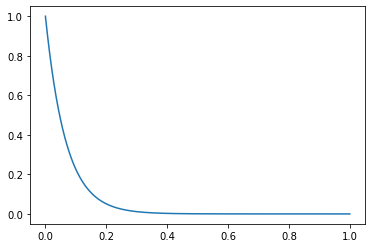

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


f = lambda t, y: -15*y

def backwards_euler(func,y0,ts):
    y = np.zeros(len(ts))
    y[0] = y0
    for i in range(len(ts)-1):
        h = ts[i+1]-ts[i]
        def G(x):
            return y[i]-x+h*func(ts[i+1],x)
        y[i+1] = fsolve(G,y[i])
    return ts,y


t_eval = np.linspace(0,1,1000)
be_sol = backwards_euler(f,1,t_eval)

plt.plot(be_sol[0],be_sol[1])


## Backwards Euler with Newtons iteration

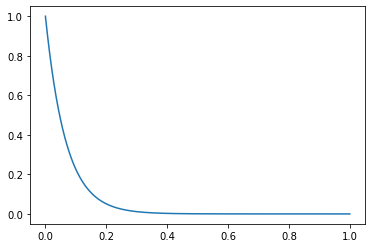

In [42]:
def backwards_euler_newt(func,y0,ts,MAXIT,EPS):
    y = np.zeros(len(ts))
    y[0] = y0
    for i in range(len(ts)-1):
        h = ts[i+1]-ts[i]
        def G(x):
            return y[i]-x+h*func(ts[i+1],x)
        its=1
        x=y[i]*1.00001            
        while its < MAXIT:
            g = G(x)
            dfdx = (func(ts[i+1],x)-func(ts[i],y[i]))/(x-y[i])
            gd = -1-h*dfdx
            x1 = x
            x = x1-g/gd         
            its += 1
            if (abs(x-x1) <= EPS): break
        y[i+1] = x
    return ts,y

t_eval = np.linspace(0,1,1000)
be_sol_newt = backwards_euler_newt(f,1,t_eval,10,1e-10)

plt.plot(be_sol_newt[0],be_sol_newt[1])

## Runge-Kutta 4. orden
$k_1 = hf(x_n,y_n)$

$k_2 = hf(x_n+h/2,y_n+k_1/2)$

$k_3 = hf(x_n+h/2,y_n+k_2/2)$

$k_4 = hf(x_n+h,y_n+k_3)$

$y_{n+1} = y_n+k_1/6 + k_2/3 + k_3/3 + k_4/6 + O(h^5)$


(-0.5, 1.5)

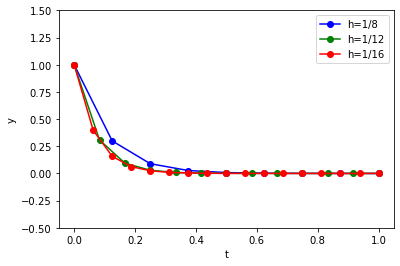

In [38]:
import numpy as np
import matplotlib.pyplot as plt


f = lambda t, y: -15*y
 
def rk4(f,h,y0,t_f):
    t=np.arange(0,t_f+h,h)
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(0, len(t)-1):
        k1 = h*f(t[i],y[i])
        k2 = h*f(t[i]+h/2,y[i]+k1/2)
        k3 = h*f(t[i]+h/2,y[i]+k2/2)
        k4 = h*f(t[i]+h,y[i]+k3)
        y[i+1] = y[i]+k1/6+k2/3+k3/3+k4/6
    return t,y

rk0 = rk4(f,1/8,1,1)
rk1 = rk4(f,1/12,1,1)
rk2 = rk4(f,1/16,1,1)


plt.plot(rk0[0],rk0[1],color='blue',marker='o',label="h=1/8")
plt.plot(rk1[0],rk1[1],color='green',marker='o',label="h=1/12")
plt.plot(rk2[0],rk2[1],color='red',marker='o',label="h=1/16")


plt.legend()
plt.ylabel("y")
plt.xlabel("t")
plt.ylim(-0.5,1.5)

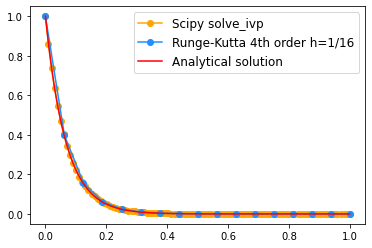

In [39]:
import numpy as np
from scipy.integrate import solve_ivp

f = lambda t, y: -15*y

sol = solve_ivp(f, [0, 1], [1], t_eval=np.linspace(0,1,100))
t_lin = np.linspace(0,1,len(sol.y[0]))
plt.plot(t_lin,sol.y[0],color='orange',marker='o',label="Scipy solve_ivp")
plt.plot(rk2[0],rk2[1],color='dodgerblue',marker='o',label="Runge-Kutta 4th order h=1/16")
def ansol(t,y0):
    return y0*np.exp(-15*t)
t_ansol = np.linspace(0,1,100)
plt.plot(t_ansol,ansol(t_ansol,1),color="red",label="Analytical solution")
plt.legend(fontsize=12)

## Runge Kutta 4 with stepdoubling adaptive stepsize

In [40]:
def rk4_asc(f,h,y0,t_s,t_f,desired_accuracy):
    y1 = [y0]
    y2 = [y0]
    t1 = [t_s]
    t2 = [t_s]
    
    def rk_par(h,f,t,y):
        k1 = h*f(t,y)
        k2 = h*f(t+h/2,y+k1/2)
        k3 = h*f(t+h/2,y+k2/2)
        k4 = h*f(t+h,y+k3)
        return k1,k2,k3,k4
    
    h=h
    i = 0
    while t1[i] < t_f:
        y1.append(0)
        y2.extend([0,0])
        t1.append(0)
        t2.extend([0,0])
        for j in range(1000):
            t1[i+1] = t1[i]+h
            t2[2*i] = t1[i]
            t2[2*i+1] = t1[i]+h/2
            ks1 = rk_par(h,f,t1[i],y1[i])
            y1[i+1] = y1[i]+ks1[0]/6+ks1[1]/3+ks1[2]/3+ks1[3]/6
            #2 half steps
            ks21 = rk_par(h/2,f,t2[2*i],y2[2*i])
            y2[2*i+1] = y2[2*i]+ks21[0]/6+ks21[1]/3+ks21[2]/3+ks21[3]/6
            ks22 = rk_par(h/2,f,t2[2*i+1],y2[2*i+1])
            y2[2*i+2] = y2[2*i+1]+ks22[0]/6+ks22[1]/3+ks22[2]/3+ks22[3]/6
            delta = abs(y2[2*i+2]-y1[i+1])
            if desired_accuracy[1] < delta:
                h = h*0.5
                continue
            if (desired_accuracy[0] < delta) & (desired_accuracy[1] > delta):
                break
            if desired_accuracy[0] > delta:
                h = h*2
                break
        i += 1
        
    
    return t1,y1

##  Runge Kutta 4(5) with adaptive stepsize


In [6]:

def rk45(f,h,y0,t_s,t_f,desired_accuracy):
    y = [y0]
    t = [t_s]
    
    
    A = [0,0,1/4,3/8,12/13,1,1/2]
    B = [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0], 
         [0, 1/4, 0, 0, 0, 0], 
         [0, 3/32, 9/32,0,0,0],
         [0, 1932/2197, -7200/2197, 7296/2197, 0 ,0],
         [0, 439/216, -8, 3680/513, -845/4104, 0],
         [0, -8/27, 2, -3544/2565, 1859/4104, -11/40]]
    C = [0, 25/216, 0, 1408/2565, 2197/4104, -1/5, 0] #fourth order coefficients
    CH = [0, 16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55] #fifth order coefficients
    CT = []
    for i in range(len(C)):
        err = CH[i]-C[i]
        CT.append(err)
    
    
    h=h
    i = 0
    evals = 0
    hs = []
    if t_s < t_f:
        def rk_par(h,f,t,y):
            k1 = h*f(t+A[1]*h, y)
            k2 = h*f(t+A[2]*h, y+B[2][1]*k1)
            k3 = h*f(t+A[3]*h, y+B[3][1]*k1+B[3][2]*k2)
            k4 = h*f(t+A[4]*h, y+B[4][1]*k1+B[4][2]*k2+B[4][3]*k3)
            k5 = h*f(t+A[5]*h, y+B[5][1]*k1+B[5][2]*k2+B[5][3]*k3+B[5][4]*k4)
            k6 = h*f(t+A[6]*h, y+B[6][1]*k1+B[6][2]*k2+B[6][3]*k3+B[6][4]*k4+B[6][5]*k5)
            return 0,k1,k2,k3,k4,k5,k6
    
        while t[i] < t_f:
            y.append(0)
            t.append(0)
            for j in range(1000):
                t[i+1]=t[i]+h
                ks = rk_par(h,f,t[i],y[i])
                y[i+1] = y[i]+CH[1]*ks[1]+CH[2]*ks[2]+CH[3]*ks[3]+CH[4]*ks[4]+CH[5]*ks[5]+CH[6]*ks[6]
                delta = abs(CT[1]*ks[1]+CT[2]*ks[2]+CT[3]*ks[3]+CT[4]*ks[4]+CT[5]*ks[5]+CT[6]*ks[6])
                evals += 6
                worst_delta = max(delta)
                if desired_accuracy < worst_delta:
                    h = h*abs(desired_accuracy/worst_delta)**(1/5)
                    continue
                if desired_accuracy > worst_delta:
                    worst_delta = max(delta)
                    hs.append(h)
                    h = min(5*h,h*abs(desired_accuracy/worst_delta)**(1/5))
                    y[i].tolist()
                    break
            i += 1
    if t_s > t_f:
        def rk_par(h,f,t,y):
            k1 = -h*f(t-A[1]*h, y)
            k2 = -h*f(t-A[2]*h, y+B[2][1]*k1)
            k3 = -h*f(t-A[3]*h, y+B[3][1]*k1+B[3][2]*k2)
            k4 = -h*f(t-A[4]*h, y+B[4][1]*k1+B[4][2]*k2+B[4][3]*k3)
            k5 = -h*f(t-A[5]*h, y+B[5][1]*k1+B[5][2]*k2+B[5][3]*k3+B[5][4]*k4)
            k6 = -h*f(t-A[6]*h, y+B[6][1]*k1+B[6][2]*k2+B[6][3]*k3+B[6][4]*k4+B[6][5]*k5)
            return 0,k1,k2,k3,k4,k5,k6
    
        while t[i] > t_f:
            y.append(0)
            t.append(0)
            for j in range(1000):
                t[i+1]=t[i]-h
                ks = rk_par(h,f,t[i],y[i])
                y[i+1] = y[i]+CH[1]*ks[1]+CH[2]*ks[2]+CH[3]*ks[3]+CH[4]*ks[4]+CH[5]*ks[5]+CH[6]*ks[6]
                delta = abs(CT[1]*ks[1]+CT[2]*ks[2]+CT[3]*ks[3]+CT[4]*ks[4]+CT[5]*ks[5]+CT[6]*ks[6])
                evals += 6
                worst_delta = max(delta)
                if desired_accuracy < worst_delta:
                    h = h*abs(desired_accuracy/worst_delta)**(1/5)
                    continue
                if desired_accuracy > worst_delta:
                    worst_delta = max(delta)
                    hs.append(h)
                    h = min(5*h,h*abs(desired_accuracy/worst_delta)**(1/5))
                    y[i].tolist()
                    break
            i += 1
    return t,np.array(y)

## RADAU5

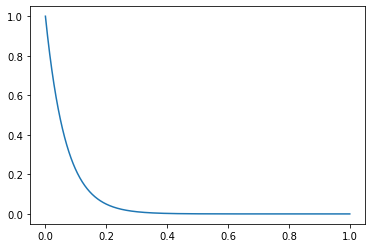

In [45]:
ra = [[(88-7*np.sqrt(6))/360,    (296-169*np.sqrt(6))/1800,  (-2+3*np.sqrt(6))/225],
    [(296+169*np.sqrt(6))/1800, (88+7*np.sqrt(6))/3600,     (-2-3*np.sqrt(6))/225],
    [(16-np.sqrt(6))/36,           (16+np.sqrt(6))/36,         1/9]]

rb = [(16-np.sqrt(6))/36, (16+np.sqrt(6))/36, 1/9]
rc = [(4-np.sqrt(6))/10,  (4+np.sqrt(6))/10, 1]


def radau5(func,y0,ts):
    n = y0.shape[0]
    y = np.zeros((len(ts),n))
    y[0] = y0
    f0 = func(ts[0],y[0])
    h0 = ts[1]-ts[0]
    zs = np.concatenate([h0*f0]*3)
    n_ts = 0
    for i in range(len(y))[:-1]:
        n_ts += 1
        h = ts[i+1]-ts[i]
        def G(z):
            z1,z2,z3 = np.split(z,[n,2*n])
            F1 = func(ts[i]+rc[0]*h,y[i]+z1)
            F2 = func(ts[i]+rc[1]*h,y[i]+z2)
            F3 = func(ts[i]+rc[2]*h,y[i]+z3)
            G1 = z1-h*(ra[0][0]*F1+ra[0][1]*F2+ra[0][2]*F3)
            G2 = z2-h*(ra[1][0]*F1+ra[1][1]*F2+ra[1][2]*F3)
            G3 = z3-h*(ra[2][0]*F1+ra[2][1]*F2+ra[2][2]*F3)
            return np.concatenate([G1,G2,G3]) 
        root = fsolve(G,zs)
        zs = root
        y[i+1] = y[i] + root[2*n:]
    return ts,y

t_eval = np.linspace(0,1,1000)
sol = radau5(f,np.array([1]),t_eval)

plt.plot(sol[0],sol[1])

## Gauss Laguerre integration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sympy import *
import math
import scipy.special as sc


def L(x,n,a):
    if n>1:
        return((2*n-1+a-x)*L(x,n-1,a)-(n-1+a)*L(x,n-2,a))/n
    if n==1:
        return 1+a-x
    if n==0:
        return 1
    


def lag_x_w(n,a,MAXIT,EPS):
    i = 1
    x=np.ones(n)
    w=np.ones(n)
    pol_2 = lambda x: L(x,n-1,a)
    pol_1 = lambda x: L(x,n,a)
    while i <= n:
        if i == 1:
            z = (1.0+a)*(3.0+0.92*a)/(1.0+2.4*n+1.8*a)
        elif i == 2:
            z += (15.0+6.25*a)/(1.0+0.9*a+2.5*n)
        else:
            ai=i-2
            z += ((1.0+2.55*ai)/(1.9*ai)+1.26*ai*a/(1.0+3.5*ai))*(z-x[i-3])/(1.0+0.3*a)
        
        its=1
        while its <= MAXIT:
            p2 = pol_2(z)
            p1 = pol_1(z)
            pp = (n*p1-(n+a)*p2)/z
            z1=z
            z=z1-p1/pp
            its += 1
            if (abs(z-z1) <= EPS): break
        x[i-1]=z
        w[i-1]=-np.exp(sc.gammaln(a+n)-sc.gammaln(float(n)))/(pp*n*p2)
        i += 1
    return x,w


## Integration of energy density and pressure

In [3]:

hbar = 6.58211899e-22# (Planck constant / 2pi) / MeV s
Grav = 6.70881e-45# gravitaion constant / hbar c^5 MeV^-2
me = 0.51099895000# electrom mass / MeV
rad_const = pi*pi/15# radiation constant / (hbar*c)^-3
kB = 8.617343e-11# Boltzmann constant / MeV/K

xs, ws = lag_x_w(10,0,10,1e-10)

def num_int_lag(f):
    Ws = [] 
    for i in range(len(xs)):
        W = np.exp(xs[i])*ws[i]
        Ws.append(W)
    I= float(0)
    for i in range(10):
        I += float(Ws[i])*f(float(xs[i]))
    return I


def rho_ep(T_MeV):
    def integrand(x):
        y = np.sqrt(x**2+(me/T_MeV)**2)
        z = np.exp(y)
        return y*x**2/(z+1)
    integral = num_int_lag(integrand)
    return T_MeV**4*2/(np.pi**2)*integral


def drhoepdT(T_MeV):
    def integrand(x):
        y = np.sqrt(x**2+(me/T_MeV)**2)
        z = np.exp(y)
        return y**2*z/(z+1)*x**2/(z+1)
    integral = num_int_lag(integrand)
    return T_MeV**3*2/(np.pi**2)*integral



def p_ep(T_MeV):
    def integrand(x):
        y = np.sqrt(x**2+(me/T_MeV)**2)
        z = np.exp(y)
        return x**4/(y*(z+1))
    integral = num_int_lag(integrand)
    return 2/(3*np.pi**2)*T_MeV**4*integral

  

## Solving only T, T_nu and h (with RK45)

In [4]:
import numpy as np
hbar = 6.58211899e-22# (Planck constant / 2pi) / MeV s
Grav = 6.70881e-45# gravitaion constant / hbar c^5 MeV^-2
me = 0.510998911# electrom mass / MeV
rad_const = np.pi**2/15# radiation constant / (hbar*c)^-3
c = 2.99792458e10# light velocity / cm/s


def expansion_eq(t,y):
    #  t=time in sec
    #  y[0] = T_nu, neutrino temperature MeV
    #  y[1] = T, MeV
    #  y[2] = h
    T_nu = y[0]
    T = y[1]
    h = y[2]
    rho_nu = 3.046*7/8*rad_const*T_nu**4
    rho_r = rad_const*T**4
    drg = 4*rho_r/T
    P_r = rho_r/3
    H = np.sqrt(8*np.pi*Grav/3)/hbar*np.sqrt(rho_ep(T) + rho_r + rho_nu)
    drdT = (drg+drhoepdT(T))/(rho_r+P_r+rho_ep(T)+p_ep(T))
    dhdt = -3*h*(H-1/T*3*H/drdT)
    return np.array([-H*T_nu,-3*H/drdT,dhdt]) 



0.0031555799564427734


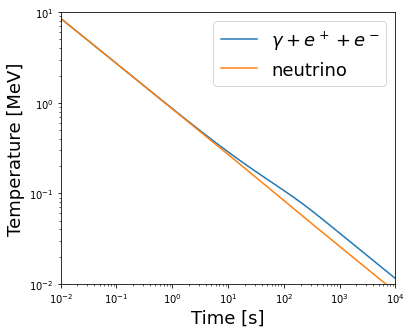

In [7]:
T_t = rk45(expansion_eq, 1/1000, np.array([100,100,3.3683e4*5.5e-10]), 0, 1e5, 1e-6)

t_ = T_t[0]
T_ = T_t[1][:,1]
T_nu_ = T_t[1][:,0]
h_eta = T_t[1][:,2]


plt.figure(figsize=(6,5))
plt.loglog(t_,T_, label='$\gamma +e^+ +e^-$')
plt.loglog(t_,T_nu_, label='neutrino')

plt.legend(fontsize=18)
plt.ylabel("Temperature [MeV]",fontsize=18)
plt.xlabel("Time [s]",fontsize=18)
plt.axis([1e-2,1e4,1e-2,1e1])
plt.savefig('temptid.pdf')
print(T_[-1])

Text(0, 0.5, '$h_\\eta$')

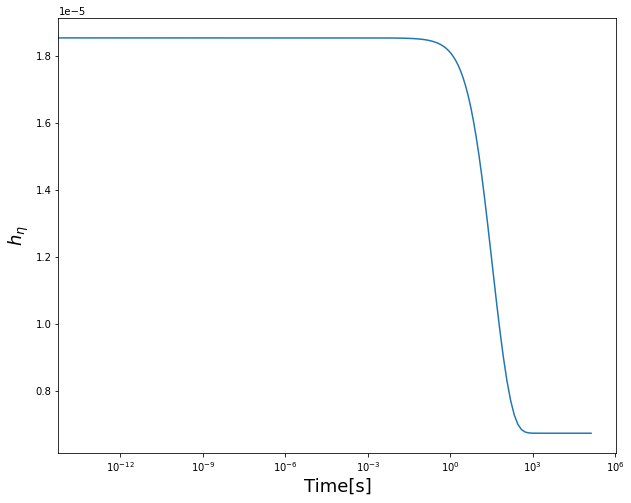

In [8]:
plt.figure(figsize=(10,8))
plt.semilogx(t_,h_eta)
plt.xlabel("Time[s]",fontsize=18)
plt.ylabel("$h_\eta$",fontsize=18)

## Neutron proton ratio the Dodelson way

0.007299966062382753


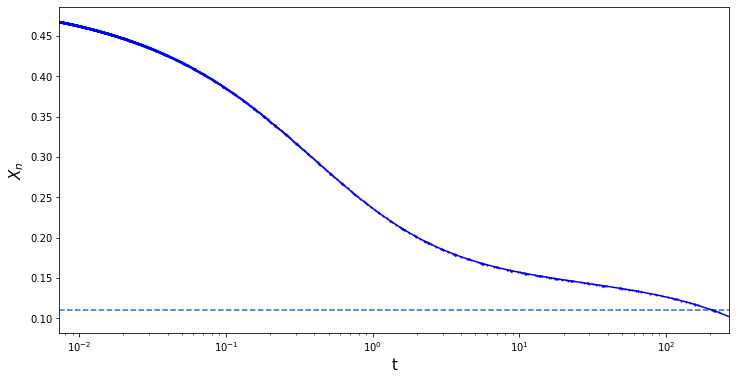

In [9]:
Q = 1.293
print(np.interp(10,T_[::-1],t_[::-1]))
def Xn_t(time,X):
    Temp = np.interp(time, t_, T_)
    Q = 1.293
    x = Q/Temp 
    conversion_rate = 255/(880.2*x**5)*(12+6*x+x**2) #pr. sek
    return conversion_rate*((1-X)*np.exp(-x)-X)


Xn_rk45_t = rk45(Xn_t, 1/1000,np.array([np.exp(-Q/10)/(np.exp(-Q/10)+1)]),np.interp(10,T_[::-1],t_[::-1]),np.interp(0.07,T_[::-1],t_[::-1]),1e-10)
plt.figure(figsize=(12,6))    

def n_decay_t(time):
    dt = time-np.interp(10, T_[::-1], t_[::-1])
    return np.exp(-dt/880.2)

for i,j in zip(Xn_rk45_t[0],range(len(Xn_rk45_t[0]))):
    #if i > time(0.1):
    Xn_0 = Xn_rk45_t[1][j]
    Xn_rk45_t[1][j] = Xn_0*n_decay_t(i)
        
plt.semilogx(Xn_rk45_t[0],Xn_rk45_t[1],color='blue',marker='o',markersize=1)
plt.xlim(np.interp(10,T_[::-1],t_[::-1]),np.interp(0.07,T_[::-1],t_[::-1]))
plt.ylabel("$X_n$",fontsize=15)
plt.xlabel("t",fontsize=15)


plt.hlines(0.11,np.interp(10,T_[::-1],t_[::-1]),np.interp(0.07,T_[::-1],t_[::-1]),linestyle="dashed")


## Neutron proton conversion rate approximations by Kawano

Text(0, 0.5, '$\\Gamma [s^-1]$')

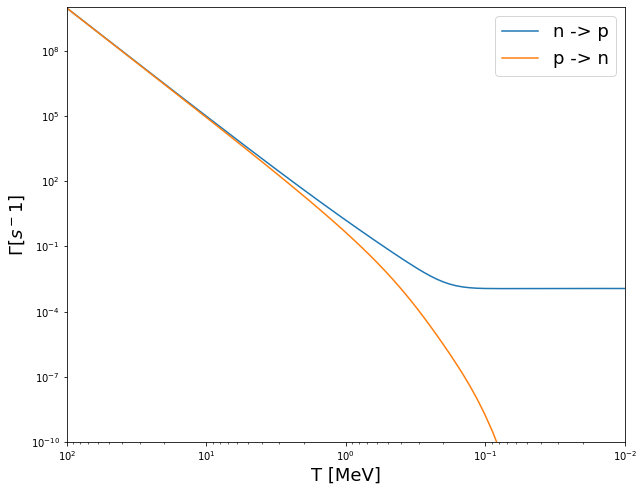

In [26]:
import numpy as np

def weak_rate(TMeV):
    q = (939.565420-938.272013)/0.51099895000
    z = me/TMeV
    tau = 880.2
    n_p = 1/tau*(1+0.565/z-6.382/(z**2)+11.108/(z**3)+36.492/(z**4)+27.512/(z**5))
    p_n = 1/tau*(5.252/z-16.229/(z**2)+18.059/(z**3)+34.181/(z**4)+27.617/(z**5))*np.exp(-q*z)
    return n_p, p_n


rate_np = weak_rate(T_)
plt.figure(figsize=(10,8))
plt.axis([1e2,1e-2,1e-10,1e10])
plt.loglog(T_,rate_np[0],label="n -> p")
plt.loglog(T_,rate_np[1],label="p -> n")
plt.legend(fontsize=18)
plt.xlabel("T [MeV]",fontsize=18)
plt.ylabel("$\Gamma [s^-1]$",fontsize=18)

## Reaction rates, all identical to the ones used in AlterBBN

In [28]:
NA = 6.02214179e23

def reaction_rate(T_MeV):
    T9 = T_MeV*11.604525006
    T912 = np.sqrt(T9)
    T932 = T9*T912
    T913 = T9**(1/3)
    T923 = T913**2
    T943 = T923**2
    T953 = T9*T923
    T954 = T9**(5/4)
    T934 = T9**(3/4)
    T9f = T9/(1 + 0.1071*T9)
    T9f13 = T9f**(1/3)
    T9f56 = T9f**(5/6)
    T9e = T9/(1 + 0.1378*T9)
    T9e13 = T9e**(1/3)
    T9e56 = T9e**(5/6)
    T9a = T9/(1 + 13.076*T9)
    T9a32 = T9a**1.5
    T9d = T9/(1 + 0.759*T9)
    T9d13 = T9d**(1/3)
    T9d56 = T9d**(5/6)

    return np.array([
        # Reaction 0: n + p -> D + gamma
        44216.*(1+3.75191*T9+1.92934*T9*T9+0.746503*T9*T9*T9+0.0197023*T9**4+3.00491e-6*T9**5)/
        (1+5.4678*T9+5.62395*T9*T9+0.489312*T9*T9*T9+0.00747806*T9**4) if T9 <=1.5 else (1.-np.sqrt(T9)*0.8504+T9*0.4895-T932*0.09623+T9*0.008471*T9-T9*2.8e-4*T932)*47420.,
        
        
        
        # Reaction 1: p + D -> 3He + gamma
        #2.65e+3/T923*np.exp(-3.720/T913)*(1. + .112*T913 + 1.99*T923+ 1.56*T9 + .162*T943 + .324*T953), 
        4.815e-14 if (T9<0.001)
        else 4.815e-14 if ((T9>=0.001) and (T9<=0.0015)) 
        else 6.409e-9 if ((T9>0.0015) and (T9<=0.0025))
        else 4.525e-7 if ((T9>0.0025) and (T9<=0.0035))
        else 4.896e-6 if ((T9>0.0035) and (T9<=0.0045))
        else 2.444e-5 if ((T9>0.0045) and (T9<=0.0055))
        else 8.086e-5 if ((T9>0.0055) and (T9<=0.0065))
        else 2.078e-4 if ((T9>0.0065) and (T9<=0.0075))
        else 4.499e-4 if ((T9>0.0075) and (T9<=0.0085))
        else 8.619e-4 if ((T9>0.0085) and (T9<=0.0095))
        else 1.506e-3 if ((T9>0.0095) and (T9<=0.0105))
        else 2.450e-3 if ((T9>0.0105) and (T9<=0.0115))
        else 3.767e-3 if ((T9>0.0115) and (T9<=0.0125))
        else 5.531e-3 if ((T9>0.0125) and (T9<=0.0135))
        else 7.816e-3 if ((T9>0.0135) and (T9<=0.0145))
        else 1.070e-2 if ((T9>0.0145) and (T9<=0.0155))
        else 1.425e-2 if ((T9>0.0155) and (T9<=0.0170))
        else 2.366e-2 if ((T9>0.0170) and (T9<=0.0190))
        else 3.659e-2 if ((T9>0.0190) and (T9<=0.0225))
        else 8.753e-2 if ((T9>0.0225) and (T9<=0.0275))
        else 1.701e-1 if ((T9>0.0275) and (T9<=0.0350))
        else 4.476e-1 if ((T9>0.035) and (T9<=0.045))
        else 8.915e-1 if ((T9>0.045) and (T9<=0.055))
        else 1.510 if ((T9>0.055) and (T9<=0.065))
        else 2.302 if ((T9>0.065) and (T9<=0.075))
        else 3.265 if ((T9>0.075) and (T9<=0.085))
        else 4.392 if ((T9>0.085) and (T9<=0.095))
        else 5.676 if ((T9>0.095) and (T9<=0.105))
        else 7.109 if ((T9>0.105) and (T9<=0.115))
        else 8.685 if ((T9>0.115) and (T9<=0.125))
        else 1.040e1 if ((T9>0.125) and (T9<=0.135))
        else 1.224e1 if ((T9>0.135) and (T9<=0.145)) 
        else 1.420e1 if ((T9>0.145) and (T9<=0.155)) 
        else 1.628e1 if ((T9>0.155) and (T9<=0.170))
        else 2.076e1 if ((T9>0.170) and (T9<=0.190))
        else 2.565e1 if ((T9>0.190) and (T9<=0.225))
        else 3.941e1 if ((T9>0.225) and (T9<=0.275))
        else 5.505e1 if ((T9>0.275) and (T9<=0.325))
        else 7.225e1 if ((T9>0.325) and (T9<=0.375))
        else 9.076e1 if ((T9>0.375) and (T9<=0.425))
        else 1.104e2 if ((T9>0.425) and (T9<=0.475))
        else 1.310e2 if ((T9>0.475) and (T9<=0.550))
        else 1.748e2 if ((T9>0.550) and (T9<=0.650))
        else 2.212e2 if ((T9>0.650) and (T9<=0.750)) 
        else 2.700e2 if ((T9>0.750) and (T9<=0.850)) 
        else 3.207e2 if ((T9>0.850) and (T9<=0.950))
        else 3.729e2 if ((T9>0.950) and (T9<=1.125))
        else 5.093e2 if ((T9>1.125) and (T9<=1.375))
        else 6.522e2 if ((T9>1.375) and (T9<=1.625))
        else 8.000e2 if ((T9>1.625) and (T9<=1.875))
        else 9.517e2 if ((T9>1.875) and (T9<=2.250))
        else 1.265e3 if ((T9>2.250) and (T9<=2.750))
        else 1.587e3 if ((T9>2.750) and (T9<=3.250))
        else 1.914e3 if ((T9>3.250) and (T9<=3.750))
        else 2.244e3 if ((T9>3.750) and (T9<=4.500)) 
        else 2.905e3 if ((T9>4.500) and (T9<=5.500)) 
        else 3.557e3 if ((T9>5.500) and (T9<=6.500))
        else 4.194e3 if ((T9>6.500) and (T9<=7.500))
        else 4.812e3 if ((T9>7.500) and (T9<=8.500))
        else 5.410e3 if ((T9>8.500) and (T9<=9.500))
        else 5.988e3 if ((T9>9.500) and (T9<=10.00))
        else 0,
        
        # Reaction 2: D + D -> n + 3He
        (1.142e-8 if T9<0.001 
        else 1.142e-8 if ((T9>=0.001) and (T9<=0.0015))
        else 5.470e-5 if ((T9>0.0015) and (T9<=0.0025)) 
        else 3.021e-3 if ((T9>0.0025) and (T9<=0.0035))
        else 3.732e-2 if ((T9>0.0035) and (T9<=0.0045)) 
        else 2.212e-1 if ((T9>0.0045) and (T9<=0.0055)) 
        else 8.546e-1 if ((T9>0.0055) and (T9<=0.0065)) 
        else 2.505 if ((T9>0.0065) and (T9<=0.0075)) 
        else 6.066 if ((T9>0.0075) and (T9<=0.0085)) 
        else 1.278e1 if ((T9>0.0085) and (T9<=0.0095)) 
        else 2.424e1 if ((T9>0.0095) and (T9<=0.0105)) 
        else 4.237e1 if ((T9>0.0105) and (T9<=0.0115)) 
        else 6.936e1 if ((T9>0.0115) and (T9<=0.0125)) 
        else 1.077e2 if ((T9>0.0125) and (T9<=0.0135)) 
        else 1.600e2 if ((T9>0.0135) and (T9<=0.0145)) 
        else 2.291e2 if ((T9>0.0145) and (T9<=0.0155)) 
        else 3.179e2 if ((T9>0.0155) and (T9<=0.0170)) 
        else 5.667e2 if ((T9>0.0170) and (T9<=0.0190)) 
        else 9.310e2 if ((T9>0.0190) and (T9<=0.0225)) 
        else 2.504e3 if ((T9>0.0225) and (T9<=0.0275)) 
        else 5.301e3 if ((T9>0.0275) and (T9<=0.0350)) 
        else 1.568e4 if ((T9>0.035) and (T9<=0.045)) 
        else 3.369e4 if ((T9>0.045) and (T9<=0.055)) 
        else 6.013e4 if ((T9>0.055) and (T9<=0.065)) 
        else 9.527e4 if ((T9>0.065) and (T9<=0.075)) 
        else 1.390e5 if ((T9>0.075) and (T9<=0.085)) 
        else 1.912e5 if ((T9>0.085) and (T9<=0.095)) 
        else 2.513e5 if ((T9>0.095) and (T9<=0.105)) 
        else 3.190e5 if ((T9>0.105) and (T9<=0.115)) 
        else 3.938e5 if ((T9>0.115) and (T9<=0.125)) 
        else 4.753e5 if ((T9>0.125) and (T9<=0.135)) 
        else 5.631e5 if ((T9>0.135) and (T9<=0.145)) 
        else 6.568e5 if ((T9>0.145) and (T9<=0.155)) 
        else 7.559e5 if ((T9>0.155) and (T9<=0.170)) 
        else 9.691e5 if ((T9>0.170) and (T9<=0.190)) 
        else 1.200e6 if ((T9>0.190) and (T9<=0.225)) 
        else 1.842e6 if ((T9>0.225) and (T9<=0.275)) 
        else 2.555e6 if ((T9>0.275) and (T9<=0.325)) 
        else 3.318e6 if ((T9>0.325) and (T9<=0.375)) 
        else 4.119e6 if ((T9>0.375) and (T9<=0.425)) 
        else 4.946e6 if ((T9>0.425) and (T9<=0.475)) 
        else 5.792e6 if ((T9>0.475) and (T9<=0.550)) 
        else 7.517e6 if ((T9>0.550) and (T9<=0.650)) 
        else 9.260e6 if ((T9>0.650) and (T9<=0.750)) 
        else 1.100e7 if ((T9>0.750) and (T9<=0.850)) 
        else 1.272e7 if ((T9>0.850) and (T9<=0.950)) 
        else 1.442e7 if ((T9>0.950) and (T9<=1.125)) 
        else 1.850e7 if ((T9>1.125) and (T9<=1.375)) 
        else 2.235e7 if ((T9>1.375) and (T9<=1.625)) 
        else 2.595e7 if ((T9>1.625) and (T9<=1.875)) 
        else 2.932e7 if ((T9>1.875) and (T9<=2.250)) 
        else 3.546e7 if ((T9>2.250) and (T9<=2.750)) 
        else 4.093e7 if ((T9>2.750) and (T9<=3.250)) 
        else 4.585e7 if ((T9>3.250) and (T9<=3.750)) 
        else 5.031e7 if ((T9>3.750) and (T9<=4.500)) 
        else 5.816e7 if ((T9>4.500) and (T9<=5.500)) 
        else 6.488e7 if ((T9>5.500) and (T9<=6.500)) 
        else 7.072e7 if ((T9>6.500) and (T9<=7.500)) 
        else 7.583e7 if ((T9>7.500) and (T9<=8.500)) 
        else 8.037e7 if ((T9>8.500) and (T9<=9.500)) 
        else 8.437e7 if ((T9>9.500) and (T9<=10.00)) 
        else 0),
        
        # Reaction 3: D + D -> p + t
        1.173e-8 if T9<0.001 
        else 1.173e-8 if ((T9>=0.001) and (T9<=0.0015)) 
        else 5.609e-5 if ((T9>0.0015) and (T9<=0.0025)) 
        else 3.092e-3 if ((T9>0.0025) and (T9<=0.0035)) 
        else 3.814e-2 if ((T9>0.0035) and (T9<=0.0045)) 
        else 2.257e-1 if ((T9>0.0045) and (T9<=0.0055)) 
        else 8.707e-1 if ((T9>0.0055) and (T9<=0.0065)) 
        else 2.549 if ((T9>0.0065) and (T9<=0.0075)) 
        else 6.164 if ((T9>0.0075) and (T9<=0.0085)) 
        else 1.297e1 if ((T9>0.0085) and (T9<=0.0095)) 
        else 2.458e1 if ((T9>0.0095) and (T9<=0.0105)) 
        else 4.290e1 if ((T9>0.0105) and (T9<=0.0115)) 
        else 7.016e1 if ((T9>0.0115) and (T9<=0.0125)) 
        else 1.088e2 if ((T9>0.0125) and (T9<=0.0135)) 
        else 1.615e2 if ((T9>0.0135) and (T9<=0.0145)) 
        else 2.310e2 if ((T9>0.0145) and (T9<=0.0155)) 
        else 3.202e2 if ((T9>0.0155) and (T9<=0.0170)) 
        else 5.698e2 if ((T9>0.0170) and (T9<=0.0190)) 
        else 9.343e2 if ((T9>0.0190) and (T9<=0.0225)) 
        else 2.502e3 if ((T9>0.0225) and (T9<=0.0275)) 
        else 5.276e3 if ((T9>0.0275) and (T9<=0.0350)) 
        else 1.549e4 if ((T9>0.035) and (T9<=0.045)) 
        else 3.307e4 if ((T9>0.045) and (T9<=0.055)) 
        else 5.868e4 if ((T9>0.055) and (T9<=0.065))
        else 9.246e4 if ((T9>0.065) and (T9<=0.075)) 
        else 1.343e5 if ((T9>0.075) and (T9<=0.085)) 
        else 1.837e5 if ((T9>0.085) and (T9<=0.095)) 
        else 2.404e5 if ((T9>0.095) and (T9<=0.105)) 
        else 3.039e5 if ((T9>0.105) and (T9<=0.115)) 
        else 3.737e5 if ((T9>0.115) and (T9<=0.125)) 
        else 4.493e5 if ((T9>0.125) and (T9<=0.135)) 
        else 5.304e5 if ((T9>0.135) and (T9<=0.145)) 
        else 6.165e5 if ((T9>0.145) and (T9<=0.155)) 
        else 7.072e5 if ((T9>0.155) and (T9<=0.170)) 
        else 9.011e5 if ((T9>0.170) and (T9<=0.190)) 
        else 1.110e6 if ((T9>0.190) and (T9<=0.225)) 
        else 1.682e6 if ((T9>0.225) and (T9<=0.275))
        else 2.309e6 if ((T9>0.275) and (T9<=0.325)) 
        else 2.974e6 if ((T9>0.325) and (T9<=0.375)) 
        else 3.663e6 if ((T9>0.375) and (T9<=0.425)) 
        else 4.371e6 if ((T9>0.425) and (T9<=0.475)) 
        else 5.089e6 if ((T9>0.475) and (T9<=0.550)) 
        else 6.543e6 if ((T9>0.550) and (T9<=0.650)) 
        else 8.001e6 if ((T9>0.650) and (T9<=0.750)) 
        else 9.448e6 if ((T9>0.750) and (T9<=0.850)) 
        else 1.087e7 if ((T9>0.850) and (T9<=0.950)) 
        else 1.228e7 if ((T9>0.950) and (T9<=1.125)) 
        else 1.565e7 if ((T9>1.125) and (T9<=1.375)) 
        else 2.882e7 if ((T9>1.375) and (T9<=1.625)) 
        else 2.181e7 if ((T9>1.625) and (T9<=1.875)) 
        else 2.461e7 if ((T9>1.875) and (T9<=2.250)) 
        else 2.976e7 if ((T9>2.250) and (T9<=2.750)) 
        else 3.440e7 if ((T9>2.750) and (T9<=3.250)) 
        else 3.863e7 if ((T9>3.250) and (T9<=3.750)) 
        else 4.251e7 if ((T9>3.750) and (T9<=4.500)) 
        else 4.946e7 if ((T9>4.500) and (T9<=5.500)) 
        else 5.552e7 if ((T9>5.500) and (T9<=6.500)) 
        else 6.077e7 if ((T9>6.500) and (T9<=7.500)) 
        else 6.529e7 if ((T9>7.500) and (T9<=8.500)) 
        else 6.912e7 if ((T9>8.500) and (T9<=9.500)) 
        else 7.228e7 if ((T9>9.500) and (T9<=10.00)) 
        else 0,
        
        # Reaction 4: n + 3He -> p + t
        7.064935e8+6.733213571736319e8*T9+1.7181155480346258e9*T9*T9-4.5367658146835446e8*T9*T9*T9
        -1.2216728981712557e8*T9**4-4.92736677238425e8*T912-1.3659670893994067e9*T932
        -6.629932739639357e8*T9**(5./2.)+4.834951929033479e8*T9**(7./2.) if T9 < 2.5 else 4.81732e8,
        
        # Reaction 5: D + t -> n + 4He
        6.2265733e8/(np.exp(0.49711597/T9)*T9**0.56785403)
        +np.exp(-0.23309803*T9*T9-1.342742/T913)*(-8.1144927e7 + 2.2315324e9*T9-2.9439669e9*T9*T9
        +1.8764462e9*T9*T9*T9 - 6.0511612e8*T9**4
        +9.5196576e7*T9**5
        -5.2901086e6*T9**6)/T923 if T9 < 2.5 else 3.40249e8,        
    
        # Reaction 6: 3He + D -> 4He + p
        3.1038385e8/(np.exp(1.6190981/T9)*T9**0.12159455)
        +np.exp(-0.0062340825*T9*T9-1.4540617/T913)*(-3.1335916e7-6.2051071e8*T9-1.8782248e9*T9*T9
        +6.5642773e8*T9*T9*T9+1.530887e8*T9**4
        -4.9542138e8*T9**(10./3.)
        -1.770285e8*T9**(11./3.)+1.14185e8*T913
        -2.516526e7*T9**(13./3.)+1.7500204e8*T923
        -1.7513362e9*T943+5.2792247e9*T953
        -3.32382e9*T9**(7./3.)+2.0346284e9*T9**(8./3.))/T923 if T9 < 2.5 else 1.55167e8,
        
        # Reaction 7: 3He + 4He -> 7Be + gamma
        np.exp(15.609867-(12.82707707/T913)-0.6666667*np.log(T9))*
        ((1-0.020478*T923+0.211995*T943)/(1+0.255059*T923+0.338573*T943)) if T9 <= 100 else 0,      
        
        # Reaction 8: 4He + T -> 7Li + gamma
        ((0.094614248-4.9273133*T9+99.358965*T9*T9-989.81236*T9*T9*T9+4368.45*T9**4+931.93597*T9**5
        -391.07855*T9**6+159.23101*T9**7-34.407594*T9**8+3.3919004*T9**9
        +0.017556217*T9**10-0.036253427*T9**11+0.0031118827*T9**12
        -0.00008714468*T9**13.)/T912)/(np.exp(8.4e-7*T9)*(1.+1.78616593*T9)**3.) if T9 < 2.5 else 807.406,
        
        # Reaction 9: 7Be + n -> 7Li + p
        6.8423032e9+1.7674863e10*T9+2.6622006e9*T9*T9-3.3561608e8*T9*T9*T9-5.9309139e6*T9**4
        -1.4987996e10*T912-1.0576906e10*T932+2.7447598e8*T9**(5/2)
        +7.6425157e7*T9**(7/2)-2.282944e7/T932/np.exp(0.050351813/T9) if T9 < 2.5 else 1.28039e9,
        
        # Reaction 10: 7Li + p -> 4He + 4He
        ((-8.9654123e7-2.5851582e8*T9-2.6831252e7*T9*T9+3.8691673e8*T913+4.9721269e8*T923
        +2.6444808e7*T943-1.2946419e6*T953-1.0941088e8*T9**(7./3.)
        +9.9899564e7*T9**(8./3.))/T923)/np.exp(7.73389632/T913)
        +(np.exp(-1.137519e0*T9*T9-8.6256687/T913)*(3.0014189e7-1.8366119e8*T9+1.7688138e9*T9*T9
        -8.4772261e9*T9*T9*T9+2.0237351e10*T9**4
        -1.9650068e10*T9**5+7.9452762e8*T9**6
        +1.3132468e10*T9**7-8.209351e9*T9**8
        -9.1099236e8*T9**9+2.7814079e9*T9**10
        -1.0785293e9*T9**11
        +1.3993392e8*T9**12)/T923) if T9 < 2.5 else 1.53403e6+84516.7,
    
        
        
        # Reaction 11: D + n -> t + gamma
        (T9*18.9+1.)*66.2,  #alterbbn bbnrate.c
    
        
        # Reaction 12: 3He + n -> 4He + gamma
        (T9*905.+1.)*6.62, #alterbbn bbnrate.c
        
        
        # Reaction 13: 6Li + n -> 7Li + gamma
        5100,
        
        # Reaction 14: 6Li + n -> 4He + 3He
        1/T932*2.54e9*np.exp(-2.39/T9)+(1-(T9/(T9*49.18+1))**1.5*0.261/T932)*1.68e8,
        
        # Reaction 15: 7Be + n -> 4He + 4He
        np.exp(-17.8984+0.2711/T9-23.8918/T913+62.2135*T913-5.2888*T9+0.3869*T953-22.6197*np.log(T9)),
        
        # Reaction 16: t + p -> 4He
        1/T923*2.2e4*np.exp(-3.869/T913)*(T913*0.108+1.+T923*1.68+T9*1.26+T943*0.551+T953*1.06),
        
        # Reaction 17: 6Li + p -> 7Be
        1.25e6/T923*np.exp(-8.415/T913)*(1.-0.252*T9+5.19e-2*T9*T9-2.92e-3*T9*T9*T9),
        
        # Reaction 18: 6Li + p -> 4He + 3He
        3.73e10/T923*np.exp(-8.413/T913-(T9/5.50)**2)*(1+0.050*T913-0.061*T923-0.021*T9+0.006*T943+0.005*T953)+1.33e10/T932*np.exp(-17.763/T9)+1.29e9/T9*np.exp(-21.820/T9),
        
        
        # Reaction 19: d + 4He -> gamma +6Li
        1.482e1/T923*np.exp(-7.435/T913)*(1.+6.572*T9+7.6e-2*T9*T9+2.48e-2*T9*T9*T9)
        +8.28e1/T932*np.exp(-7.904/T9),
        
        # Reaction 20: 3He + 3He -> p + p + 4He
        5.59e10/T923*np.exp(-12.277/T913)*(1.-0.135*T9+2.54e-2*T9*T9 - 1.29e-3*T9*T9*T9),
        
        # Reaction 21: 7Li + d -> n + 4He + 4He
        2.92e11/T923*np.exp(-10.259/T913),
        
        # Reaction 22: 7Be + d -> p + 4He + 4He
        1/T923*1.07e12*np.exp(-12.428/T913),
        
        # Reaction 23: 3He + t -> 6Li + gamma
        1.2201e6/T923*np.exp(-7.73436/T913)*(1.+5.38722e-2*T913
        -.214*(1.+.377*T913)*T923
        +.2733*(1.+.959*T913)*T943
        -1.53e-2*(1.+.959*T913)*T9*T9)*
        (1.-.213646*T923+.136643*T943-7.65244e-3*T9*T9),
        
        # Reaction 24: 6Li + d -> n + 7Be
        1.48e12/T923*np.exp(-10.135/T913),
        
        # Reaction 25: 6Li + d -> p + 7Li
        1.48e12/T923*np.exp(-10.135/T913),
        
        # Reaction 26: 3He + t -> d + 4He
        5.46e9*-(T9/(1.+.128*T9))**(.8333333)/T932*np.exp(-7.733/((T9/(1.+.128*T9))**(.333333))),
        
        # Reaction 27: t + t -> n + n + 4He
        1.67e9/T923*np.exp(-4.872/T913)*(1.+8.6e-2*T913-.455*T923-.272*T9
        +.148*T943+.225*T953),

        # Reaction 28: 3He + t -> n + p + 4He
        7.71e9*(T9/(1.+.115*T9))**.8333333/T932*np.exp(-7.733/((T9/(1.+.115*T9))**.333333)),
        
        # Reaction 29: 7Li + t -> n + 9Be
        2.98e10/T923*np.exp(-11.333/T913)*(1.-.122*T923),
        
        # Reaction 30: 7Be + t -> p + 9Be
        1.1*2.98e10/T923*np.exp(-13.7307/T913)*(1.-.122*T923
        +1.32/(T943-.127*T923+7.42e-2)),

        # Reaction 31: 7Li + 3He -> p + 9Be
        1.6*2.98e10/T923*np.exp(-17.992/T913)*(1.-.122*T923
        +1.32/(T943-.127*T923+7.42e-2)),
        
        # Reaction 32: 7Li + n -> gamma + 8Li
        3.144e3+4.26e3/T932*np.exp(-2.576/T9),
        
        # Reaction 33: 10B + n -> gamma + 11B
        66200,
        
        # Reaction 34: 11B + n -> gamma + 12B
        1/T932*2400.*np.exp(-0.223/T9)+729.,
        
        # Reaction 35: 11C + n -> p + 11B
        (1.-T912*0.048+T9*0.01)*1.69e8,
        
        # Reaction 36: 10B + n -> 4He + 7Li 
        2.2e7*(1.+1.064*T9),
        
        # Reaction 37: 7Be + p -> 8B + gamma
        2.61e5/T923*np.exp(-10.264/T913)*(1.-5.11e-2*T9+ 4.68e-2*T9*T9-6.6e-3*T9*T9*T9
        +3.12e-4*T9*T9*T9*T9)+ 2.05e3/T932*np.exp(-7.345/T9),
        
        # Reaction 38: 9Be + p -> 10B + gamma
        1/T923*1.33e7*np.exp(-10.359/T913-T9/0.846*T9/0.846)*(T913*0.04+1.+T923*1.52
        +T9*0.428+T943*2.15
        +T953*1.54)
        +T932*96400.*np.exp(-3.445/T9)+1/T932*2.72e6*np.exp(-10.62/T9),
        
        # Reaction 39: 10B + p -> 11C + gamma
        1/T923*1.68e6*np.exp(-1/T913*12.064)/
        ((T923-0.0273**2.)+4.69e-4)*(1.+0.977*T9+1.87*T9*T9-0.272*T9*T9*T9+0.013*T9*T9*T9*T9),
        
        # Reaction 40: 11B + p -> 12C + gamma
        1/T923*4.58e7*np.exp(-1/T913*12.097-(T9/0.6)**2.)*(1.+0.353*T9-0.842*T9*T9)
        +1/T932*6.82e3*np.exp(-1.738/T9)+2.8e4*T9**0.104*np.exp(-3.892/T9),
        
        # Reaction 41: 11C + p ->12N + gamma
        1/T923*42400.*np.exp(-13.658/T913-T9/1.627*T9/1.627)*(T913*0.031+1.
        +T923*3.11+T9*0.665
        +T943*4.61+T953*2.5)
        +1/T932*8840.*np.exp(-7.021/T9),
        
        # Reaction 42: 12B + p -> n + 12C
        1/T923*4.02e11*np.exp(-12.12/T913),
        
        # Reaction 43: 9Be + p -> 4He + 6Li
        #2.11e11/T923*np.exp(-10.361/T913-(T9/0.4)**2.)*(1.-0.189*T9+3.52e1*T9*T9)
        #+5.24e8/T932*np.exp(-3.446/T9)+4.65e8*np.exp(-4.396/T9)/(T9**0.293),
        
        2.11e11/T923*np.exp(-10.359/T913-(T9/0.520)**2)*(1+0.04*T913+1.09*T923+0.307*T9+3.21*T943+2.3*T953)
        +4.51e8/T9*np.exp(-3.046/T9)+6.70e8/T934*np.exp(-5.160/T9),
        
        # Reaction 44: 10B + p -> 4He + 7Be
        1.26e11/T923*np.exp(-12.062/T913-(T9/4.402)**2)*(1+0.035*T913-0.498*T923-0.121*T9+0.300*T943+0.184*T953)
        +2.59e9/T9*np.exp(-12.260/T9),
        
        # Reaction 45: 12B + p -> 4He + 9Be
        1/T923*2.01e11*np.exp(-12.12/T913),
        
        # Reaction 46: 6Li + 4He -> gamma + 10B
        1/T923*4.06e6*np.exp(-18.79/T913-T9/1.326*T9/1.326)*(T913*0.022+1.+T923*1.54
        +T9*0.239+T943*2.2
        +T953*0.869)
        +1/T932*1910.*np.exp(-3.484/T9)+10100./T9*np.exp(-7.269/T9),
        
        # Reaction 47: 7Li + 4He -> gamma + 11B: 
        3.55e7/T923*np.exp(-19.161/T913-(T9/4.195)**2)*(1+0.022*T913+0.775*T923+0.118*T9+0.884*T943+0.342*T953)
        +3.33e2/T932*np.exp(-2.977/T9)+4.10e4/T9*np.exp(-6.227/T9),
        
        # Reaction 48: 7Be + 4He -> gamma + 11C
        8.45e7/T923*np.exp(-23.212/T913-(T9/4.769)**2)*(1+0.018*T913+0.488*T923+0.061*T9+0.296*T943+0.095*T953)
        +1.25e4/T932*np.exp(-6.510/T9)+1.29e5/T954*np.exp(-10.039/T9),
        
        # Reaction 49: 8B + 4He -> p + 11C
        1/T923*1.08e15*np.exp(-27.36/T913),
        
        # Reaction 50: 8Li + 4He -> n + 11B
        (T9/(T9/15.1+1.))**(5./6.)*8.62e13/T932*np.exp(-19.461/((T9/(T9/15.1+1.))**(1./3.))),
        
        # Reaction 51: 9Be + 4He -> n + 12C
        1/T923*4.62e13*np.exp(-23.87/T913-T9/0.049*T9/0.049)*(T913*0.017+1.
        +T923*8.57+T9*1.05
        +T943*74.51+T953*23.15)
        +1/T932*7.34e-5*np.exp(-1.184/T9)+1/T932*0.227*np.exp(-1.834/T9)
        +1/T932*1.26e5*np.exp(-4.179/T9)+np.exp(-12.732/T9)*2.4e8,
        
        # Reaction 52: 9Be + d -> n + 10B
        1/T923*7.16e8*np.exp(6.44-12.6/T913),
        
        # Reaction 53: 10B + d -> p + 11B
        1/T923*9.53e8*np.exp(7.3-14.8/T913),
        
        # Reaction 54: 11B + d -> n + 12C
        1/T923*1.41e9*np.exp(7.4-14.8/T913),
        
        # Reaction 55: 4He + 4He + n -> gamma + 9Be
        2.59e-6/((T9*0.344+1.)*(T9*T9))*np.exp(-1.062/T9),
        
        # Reaction 56: 3*4He -> 12C + gamma
        1/T932*2.79e-8/T932*np.exp(-4.4027/T9)+1/T932*1.35e-8*np.exp(-24.811/T9),
        
        # Reaction 57: 8Li + p -> n + 4He + 4He
        1/T923*8.65e9*np.exp(-8.52/T913-T9/2.53*T9/2.53)+1/T932*2.31e9*np.exp(-4.64/T9),
        
        # Reaction 58: 8B + n -> p + 4He + 4He
        4.02e8,
        
        # Reaction 59: 9Be + p -> d + 4He + 4He
        1/T923*2.11e11*np.exp(-10.359/T913-T9/0.52*T9/0.52)*(T913*0.04+1.
        +T923*1.09+T9*0.307
        +T943*3.21+T953*2.3)
        +5.79e8/T9*np.exp(-3.046/T9)+1/T934*8.5e8*np.exp(-5.8/T9),
        
        # Reaction 60: 11B + p -> 3*4He
        1/T923*2.2e12*np.exp(-12.095/T913-T9/1.644*T9/1.644)*(T913*0.034+1.
        +T923*0.14+T9*0.034
        +T943*0.19+T953*0.116)
        +1/T932*4.03e6*np.exp(-1.734/T9)+1/T932*6.73e9*np.exp(-6.262/T9)+3.88e9/T9*np.exp(-14.154/T9),
        
        # Reaction 61: 11C + n -> 3*4He
        1.58e8,
        
        # Reaction 62: 12C + n -> gamma + 13C
        450,
        
        # Reaction 63: 13C + n -> gamma + 14C
        1/T932*2.38e5*np.exp(-1.67/T9)+119.,
        
        # Reaction 64: 14N + n -> gamma + 15N
        9940,
        
        # Reaction 65: 13N + n -> p + 13C
        1.178e8*(1.+3.36e-1*T9-3.792e-2*T9*T9+2.02e-3*T9*T9*T9)*(1.+1.131*np.exp(-1.2892e1/T9+1.9e-2*T9)),
        
        # Reaction 66: 14N + n -> p -> 14C
        (T912*0.361+1.+T9*0.502)*2.39e5+1.112e8/T912*np.exp(-4.983/T9),
        
        # Reaction 67:  15O + n -> p + 15N
        1.158e8*(1.+2.19e-1*T9-2.9e-2*T9*T9+1.73e-3*T9*T9*T9)*(1.+3.87e-1*np.exp(-26.171/T9+1.18e-1*T9)),
        
        # Reaction 68: 15O + n -> 4He + 12C
        (T912*0.188+1.+T9*0.015)*3.5e7,
        
        # Reaction 69: 12C + p -> gamma + 13N
        2.e7/T923*np.exp(-13.692/T913-(T9/0.46)**2.)*(1.+9.89*T9-59.8*T9*T9+266.*T9*T9*T9)
        +1e5/T932*np.exp(-4.913/T9)+4.24e5/T932*np.exp(-21.62/T9),
        
        # Reaction 70: 13C + p -> gamma + 14N
        (9.57e7*1/T923*np.exp(-13.720*1/T913-T9*T9)*(1.+3.56*T9)+1.5e6*1/T932*np.exp(-5.930/T9)
        +6.83e5*T9**(8.64e-1)*np.exp(-12.057/T9))*(1.-2.07*np.exp(-37.938/T9)),
        
        # Reaction 71: 14C + p -> gamma + 15N
        1/T923*6.8e6*np.exp(-13.741/T913-T9/5.721*T9/5.721)*(T913*0.03+1.+T923*0.503
        +T9*0.107+T943*0.213
        +T953*0.115)
        +1/T932*5360.*np.exp(-3.811/T9)+1/T913*98200.*np.exp(-4.739/T9),
        
        # Reaction 72: 13N + p -> gamma + 14O
        1/T923*4.04e7*np.exp(-15.202/T913-T9/1.191*T9/1.191)*(T913*0.027+1.
        -T923*0.803-T9*0.154
        +T943*5.+T953*2.44)
        +1/T932*2.43e5*np.exp(-6.348/T9),
        
        
        # Reaction 73: 14N + p -> gamma + 15O
        1/T923*4.9e7*np.exp(-15.228/T913-T9/3.294*T9/3.294)*(T913*0.027+1.
        -T923*0.778
        -T9*0.149+T943*0.261
        +T953*0.127)
        +1/T932*2370.*np.exp(-3.011/T9)+np.exp(-12.53/T9)*21900.,
        
        # Reaction 74:  N15 + p -> gamma + 16O
        1/T923*9.78e8*np.exp(-15.251/T913-T9/0.45*T9/0.45)*(T913*0.027+1.+T923*0.219
        +T9*0.042+T943*6.83
        +T953*3.32)
        +1/T932*11100.*np.exp(-3.328/T9)+1/T932*14900.*np.exp(-4.665/T9)+1/T932*3.8e6*np.exp(-11.048/T9),
        
        # Reaction 75: 15N + p -> 4He + 12C
        4.17e7*T9**0.917*np.exp(-3.292/T9) if T9>2.5 else 1.12e12*1/T923*np.exp(-15.253*1/T913-(T9/0.28)**2.)*(1.+4.95*T9+143.*T9*T9)
        +1.01e8*1/T932*np.exp(-3.643/T9)+1.19e9*1/T932*np.exp(-7.406/T9),
        
        # Reaction 76: 12C + 4He -> gamma + 16O
        1.04e8/(T9*T9)*np.exp(-32.12/T913-T9/3.496*T9/3.496)/((1/T923*0.0489+1.)**2.)
        +1.76e8/(T9*T9)/((1/T923*0.2654+1.)**2.)*np.exp(-32.12/T913)
        +1/T932*1250.*np.exp(-27.499/T9)+T9**5.*0.0143*np.exp(-15.541/T9),
        
        # Reaction 77: 10B + 4He -> p + 13C
        1/T923*9.6e14*np.exp(-27.99/T913),
        
        # Reaction 78: 11B + 4He -> p + 14C
        1/T923*5.37e11*np.exp(-28.234/T913-T9/0.347*T9/0.347)*(T913*0.015+1.
        +T923*5.575+T9*0.576
        +T943*15.888
        +T953*4.174)
        +1/T932*0.00544*np.exp(-2.827/T9)+1/T932*336.*np.exp(-5.178/T9)+5.32e6/(T9**0.375)*np.exp(-11.617/T9),
        
        # Reaction 79: 11C + 4He -> p + 14N
        ((T9/(T9*0.0478+1.+T953*0.00756/((T9*0.0478+1.)**(2./3.))))**(5./6.)*
        7.15e15*1/T932*np.exp(-31.883/((T9/(T9*0.0478+1.+T953*0.00756/((T9*0.0478+1.)**2./3.)))**(1./3.))))*(1.+0.140*np.exp(-0.275/T9-0.210*T9)),
        
        # Reaction 80: 12N + 4He -> p + 15O
        1/T923*5.59e16*np.exp(-35.6/T913),
        
        # Reaction 81: 13N + 4He -> p + 16O
        (T9/(T9*0.0776+1.+T953*0.0264/((T9*0.0776+1.)**(2./3.))))**(5./6.)
        *3.23e17*1/T932*np.exp(-35.829/((T9/(T9*0.0776+1.+T953*0.0264/((T9*0.0776+1.)**(2./3.))))**(1./3.))),
        
        # Reaction 82: 10B + 4He -> n + 13N
        1/T923*1.2e13*np.exp(-27.989/T913-T9/9.589*T9/9.589),
        
        # Reaction 83: 11B + 4He -> n + 14N
        1/T923*6.97e12*np.exp(-28.234/T913-T9/0.14*T9/0.14)*(T913*0.015+1.+T923*8.115
        +T9*0.838+T943*39.804
        +T953*10.456)
        +1/T932*1.79*np.exp(-2.827/T9)+1/T932*1710.*np.exp(-5.178/T9)+T9**0.6*4.49e6*np.exp(-8.596/T9),
        
        # Reaction 84: 12B + 4He -> n + 15N
        1/T923*3.04e15*np.exp(-28.45/T913),
        
        # Reaction 85: 13C + 4He -> n + 16O
        7.59e6*T9**1.078*np.exp(-12.056/T9)*(1.+7.3318e1*np.exp(-58.176/T9-1.98e-1*T9)) if T9>4 else (3.78e14/T9/T9*np.exp(-32.333*1/T913-(T9/0.71)**2.)*(1.+4.68e1*T9-2.92e2*T9*T9+7.38e2*T9*T9*T9)
        +2.3e7*T9**0.45*np.exp(-13.03/T9))*(1.+7.3318e1*np.exp(-58.176/T9-1.98e-1*T9)),
        
        # Reaction 86: 11B + d -> p + 12B
        .60221*((4.97838e13*np.exp(-14.8348*(.0215424+1./T9)**(1./3.))*(.0215424+1./T9)**(1./6.)/T912)/
        (46.42+T9)+np.exp(-14.835*1/T913)*(6.52581e9+(1.56921e11-4.074e9*T913+1.28302e9*T9)*
        1/T923)),
        
        # Reaction 87: 12C + d -> p + 13C
        6.60999e12*1/T923*np.exp(-16.8242*1/T913-.234041*T923)*
        (1.-np.exp(-1.10272*(1.+.921391*T913)*(1.+.921391*T913))),
        
        # Reaction 88: 13C + d -> p + 14C
        7.23773e12*1/T923*np.exp(-16.8869*1/T913-.242434*T923)*
        (1.-np.exp(-1.08715*(1.+.944456*T913)*(1.+.944456*T913)))
        
        
        ])/NA

## Reaction database

In [13]:
MeV_to_GK = 11.6045250061598 
Dalton = 931.49410242

In [18]:
class Reactions:
    def __init__(self,reac_number, reac, prod, Ns, fr, B):
        self.reac_number = reac_number
        self.reac = reac
        self.prod = prod
        self.fr = fr
        self.B = B
        self.Ns = Ns
    

In [19]:
reaction_list = []
reaction0 = Reactions(0,["n","p","0"],["d","0","0"],[1,1,0,1,0,0],0,25.815/MeV_to_GK)
reaction_list.append(reaction0)

reaction1 = Reactions(1,["p","d","0"],["He3","0","0"],[1,1,0,1,0,0],0,63.749/MeV_to_GK)
reaction_list.append(reaction1)

reaction2 = Reactions(2,["d","0","0"],["He3","n","0"],[2,0,0,1,1,0],0,37.934/MeV_to_GK)
reaction_list.append(reaction2)

reaction3 = Reactions(3,["d","0","0"],["t","p","0"],[2,0,0,1,1,0],0,46.798/MeV_to_GK)
reaction_list.append(reaction3)

reaction4 = Reactions(4,["He3","n","0"],["t","p","0"],[1,1,0,1,1,0],0,8.863/MeV_to_GK)
reaction_list.append(reaction4)

reaction5 = Reactions(5,["t","d","0"],["He4","n","0"],[1,1,0,1,1,0],0,204.116/MeV_to_GK)
reaction_list.append(reaction5)

reaction6 = Reactions(6,["He3","d","0"],["He4","p","0"],[1,1,0,1,1,0],0,212.979/MeV_to_GK)
reaction_list.append(reaction6)

reaction7 = Reactions(7,["He3","He4","0"],["Be7","0","0"],[1,1,0,1,0,0],0,18.412/MeV_to_GK)
reaction_list.append(reaction7)

reaction8 = Reactions(8,["He4","t","0"],["Li7","0","0"],[1,1,0,1,0,0],0,28.629/MeV_to_GK)
reaction_list.append(reaction8)

reaction9 = Reactions(9,["Be7","n","0"],["Li7","p","0"],[1,1,0,1,1,0],0,19.080/MeV_to_GK)
reaction_list.append(reaction9)

reaction10 = Reactions(10,["Li7","p","0"],["He4","0","0"],[1,1,0,2,0,0],0,201.302/MeV_to_GK)
reaction_list.append(reaction10)

reactiond0 = Reactions("d0",["t"],["He3"],[1,0,0,1,0,0],1.78141141239e-9,0)
reaction_list.append(reactiond0)

reaction11 = Reactions(11,["d","n","0"],["t","0","0"],[1,1,0,1,0,0],0,72.612/MeV_to_GK)
reaction_list.append(reaction11)

reaction12 = Reactions(12,["He3","n","0"],["He4","0","0"],[1,1,0,1,0,0],0,238.794/MeV_to_GK)
reaction_list.append(reaction12)

reaction13 = Reactions(13,["Li6","n","0"],["Li7","0","0"],[1,1,0,1,0,0],0,84.132/MeV_to_GK)
reaction_list.append(reaction13)

reaction14 = Reactions(14,["Li6","n","0"],["He4","t","0"],[1,1,0,1,1,0],0,55.503/MeV_to_GK)
reaction_list.append(reaction14)

reaction15 = Reactions(15,["Be7","n","0"],["He4","0","0"],[1,1,0,2,0,0],0,220.382/MeV_to_GK)
reaction_list.append(reaction15)

reaction16 = Reactions(16,["t","p","0"],["He4","0","0"],[1,1,0,1,0,0],0,229.931/MeV_to_GK)
reaction_list.append(reaction16)

reaction17 = Reactions(17,["Li6","p","0"],["Be7","0","0"],[1,1,0,1,0,0],0,65.052/MeV_to_GK)
reaction_list.append(reaction17)

reaction18 = Reactions(18,["Li6","p","0"],["He4","He3","0"],[1,1,0,1,1,0],0,46.640/MeV_to_GK)
reaction_list.append(reaction18)

reaction19 = Reactions(19,["d","He4","0"],["Li6","0","0"],[1,1,0,1,0,0],0,17.109/MeV_to_GK)
reaction_list.append(reaction19)

reaction20 = Reactions(20,["He3","0","0"],["p","He4","0"],[2,0,0,2,1,0],0,149.229/MeV_to_GK)
reaction_list.append(reaction20)

reaction21 = Reactions(21,["Li7","d","0"],["n","He4","0"],[1,1,0,1,2,0],0,175.487/MeV_to_GK)
reaction_list.append(reaction21)

reaction22 = Reactions(22,["Be7","d","0"],["p","He4","0"],[1,1,0,1,2,0],0,194.566/MeV_to_GK)
reaction_list.append(reaction22)

reaction23 = Reactions(23,["He3","t","0"],["Li6","0","0"],[1,1,0,1,0,0],0,183.290/MeV_to_GK)
reaction_list.append(reaction23)

reaction24 = Reactions(24,["Li6","d","0"],["n","Be7","0"],[1,1,0,1,1,0],0,39.237/MeV_to_GK)
reaction_list.append(reaction24)

reaction25 = Reactions(25,["Li6","d","0"],["p","Li7","0"],[1,1,0,1,1,0],0,58.317/MeV_to_GK)
reaction_list.append(reaction25)

reaction26 = Reactions(26,["He3","t","0"],["d","He4","0"],[1,1,0,1,1,0],0,166.181/MeV_to_GK)
reaction_list.append(reaction26)

reaction27 = Reactions(27,["t","0","0"],["n","He4","0"],[2,0,0,2,1,0],0,131.503/MeV_to_GK)
reaction_list.append(reaction27)

reaction28 = Reactions(28,["He3","t","0"],["n","p","He4"],[1,1,0,1,1,1],0,140.366/MeV_to_GK)
reaction_list.append(reaction28)

reaction29 = Reactions(29,["Li7","t","0"],["n","Be9","0"],[1,1,0,1,1,0],0,121.136/MeV_to_GK)
reaction_list.append(reaction29)

reaction30 = Reactions(30,["Be7","t","0"],["p","Be9","0"],[1,1,0,1,1,0],0,140.215/MeV_to_GK)
reaction_list.append(reaction30)

reaction31 = Reactions(31,["Li7","He3","0"],["p","Be9","0"],[1,1,0,1,1,0],0,129.999/MeV_to_GK)
reaction_list.append(reaction31)

reaction32 = Reactions(32,["Li7","n","0"],["Li8","0","0"],[1,1,0,1,0,0],0,23.589/MeV_to_GK)
reaction_list.append(reaction32)

reaction33 = Reactions(33,["B10","n","0"],["B11","0","0"],[1,1,0,1,0,0],0,132.920/MeV_to_GK)
reaction_list.append(reaction33)

reaction34 = Reactions(34,["B11","n","0"],["B12","0","0"],[1,1,0,1,0,0],0,39.111/MeV_to_GK)
reaction_list.append(reaction34)

reaction35 = Reactions(35,["C11","n","0"],["p","B11","0"],[1,1,0,1,1,0],0,32.086/MeV_to_GK)
reaction_list.append(reaction35)

reaction36 = Reactions(36,["B10","n","0"],["He4","Li7","0"],[1,1,0,1,1,0],0,32.371/MeV_to_GK)
reaction_list.append(reaction36)

reaction37 = Reactions(37,["Be7","p","0"],["B8","0","0"],[1,1,0,1,0,0],0,1.595/MeV_to_GK)
reaction_list.append(reaction37)

reaction38 = Reactions(38,["Be9","p","0"],["B10","0","0"],[1,1,0,1,0,0],0,76.424/MeV_to_GK)
reaction_list.append(reaction38)

reaction39 = Reactions(39,["B10","p","0"],["C11","0","0"],[1,1,0,1,0,0],0,100.834/MeV_to_GK)
reaction_list.append(reaction39)

reaction40 = Reactions(40,["B11","p","0"],["C12","0","0"],[1,1,0,1,0,0],0,185.173/MeV_to_GK)
reaction_list.append(reaction40)

reaction41 = Reactions(41,["C11","p","0"],["N12","0","0"],[1,1,0,1,0,0],0,6.979/MeV_to_GK)
reaction_list.append(reaction41)

reaction42 = Reactions(42,["B12","p","0"],["n","C12","0"],[1,1,0,1,1,0],0,146.061/MeV_to_GK)
reaction_list.append(reaction42)

reaction43 = Reactions(43,["Be9","p","0"],["He4","Li6","0"],[1,1,0,1,1,0],0,24.663/MeV_to_GK) #WEIRD
reaction_list.append(reaction43)

reaction44 = Reactions(44,["B10","p","0"],["He4","Be7","0"],[1,1,0,1,1,0],0,13.291/MeV_to_GK)
reaction_list.append(reaction44)

reaction45 = Reactions(45,["B12","p","0"],["He4","Be9","0"],[1,1,0,1,1,0],0,79.903/MeV_to_GK)
reaction_list.append(reaction45)

reaction46 = Reactions(46,["Li6","He4","0"],["B10","0","0"],[1,1,0,1,0,0],0,51.761/MeV_to_GK)
reaction_list.append(reaction46)

reaction47 = Reactions(47,["Li7","He4","0"],["B11","0","0"],[1,1,0,1,0,0],0,100.549/MeV_to_GK)
reaction_list.append(reaction47)

reaction48 = Reactions(48,["Be7","He4","0"],["C11","0","0"],[1,1,0,1,0,0],0,87.543/MeV_to_GK)
reaction_list.append(reaction48)

reaction49 = Reactions(49,["B8","He4","0"],["p","C11","0"],[1,1,0,1,1,0],0,85.948/MeV_to_GK)
reaction_list.append(reaction49)

reaction50 = Reactions(50,["Li8","He4","0"],["n","B11","0"],[1,1,0,1,1,0],0,76.960/MeV_to_GK)
reaction_list.append(reaction50)

reaction51 = Reactions(51,["Be9","He4","0"],["n","C12","0"],[1,1,0,1,1,0],0,66.158/MeV_to_GK)
reaction_list.append(reaction51)

reaction52 = Reactions(52,["Be9","d","0"],["n","B10","0"],[1,1,0,1,1,0],0,50.609/MeV_to_GK)
reaction_list.append(reaction52)

reaction53 = Reactions(53,["B10","d","0"],["p","B11","0"],[1,1,0,1,1,0],0,107.105/MeV_to_GK)
reaction_list.append(reaction53)

reaction54 = Reactions(54,["B11","d","0"],["n","C12","0"],[1,1,0,1,1,0],0,159.357/MeV_to_GK)
reaction_list.append(reaction54)

#reaction55 = Reactions(55,["He4","n","0"],["Be9","0","0"],[2,1,0,1,0,0],0,18.262/MeV_to_GK) #WEIRD
#reaction_list.append(reaction55)

#reaction56 = Reactions(56,["He4","0","0"],["C12","0","0"],[3,0,0,1,0,0],0,84.420/MeV_to_GK) #WEIRD
#reaction_list.append(reaction56)

reaction57 = Reactions(57,["Li8","p","0"],["n","He4","0"],[1,1,0,1,2,0],0,177.713/MeV_to_GK)
reaction_list.append(reaction57)

reaction58 = Reactions(58,["B8","n","0"],["p","He4","0"],[1,1,0,1,2,0],0,218.787/MeV_to_GK)
reaction_list.append(reaction58)

reaction59 = Reactions(59,["Be9","p","0"],["d","He4","0"],[1,1,0,1,2,0],0,7.554/MeV_to_GK)
reaction_list.append(reaction59)

reaction60 = Reactions(60,["B11","p","0"],["He4","0","0"],[1,1,0,3,0,0],0,100.753/MeV_to_GK)
reaction_list.append(reaction60)

reaction61 = Reactions(61,["C11","n","0"],["He4","0","0"],[1,1,0,3,0,0],0,132.838/MeV_to_GK)
reaction_list.append(reaction61)

reaction62 = Reactions(62,["C12","n","0"],["C13","0","0"],[1,1,0,1,0,0],0,57.400/MeV_to_GK)
reaction_list.append(reaction62)

reaction63 = Reactions(63,["C13","n","0"],["C14","0","0"],[1,1,0,1,0,0],0,94.884/MeV_to_GK)
reaction_list.append(reaction63)

reaction64 = Reactions(64,["N14","n","0"],["N15","0","0"],[1,1,0,1,0,0],0,125.715/MeV_to_GK)
reaction_list.append(reaction64)

reaction65 = Reactions(65,["N13","n","0"],["p","C13","0"],[1,1,0,1,1,0],0,34.846/MeV_to_GK)
reaction_list.append(reaction65)

reaction66 = Reactions(66,["N14","n","0"],["p","C14","0"],[1,1,0,1,1,0],0,7.263/MeV_to_GK)
reaction_list.append(reaction66)

reaction67 = Reactions(67,["O15","n","0"],["p","N15","0"],[1,1,0,1,1,0],0,41.037/MeV_to_GK)
reaction_list.append(reaction67)

reaction68 = Reactions(68,["O15","n","0"],["He4","C12","0"],[1,1,0,1,1,0],0,98.659/MeV_to_GK)
reaction_list.append(reaction68)

reaction69 = Reactions(69,["C12","p","0"],["N13","0","0"],[1,1,0,1,0,0],0,22.554/MeV_to_GK)
reaction_list.append(reaction69)

reaction70 = Reactions(70,["C13","p","0"],["N14","0","0"],[1,1,0,1,0,0],0,87.621/MeV_to_GK)
reaction_list.append(reaction70)

reaction71 = Reactions(71,["C14","p","0"],["N15","0","0"],[1,1,0,1,0,0],0,118.452/MeV_to_GK)
reaction_list.append(reaction71)

reaction72 = Reactions(72,["N13","p","0"],["O14","0","0"],[1,1,0,1,0,0],0,53.705/MeV_to_GK)
reaction_list.append(reaction72)

reaction73 = Reactions(73,["N14","p","0"],["O15","0","0"],[1,1,0,1,0,0],0,84.678/MeV_to_GK)
reaction_list.append(reaction73)

reaction74 = Reactions(74,["N15","p","0"],["O16","0","0"],[1,1,0,1,0,0],0,140.733/MeV_to_GK)
reaction_list.append(reaction74)

reaction75 = Reactions(75,["N15","p","0"],["He4","C12","0"],[1,1,0,1,1,0],0,57.622/MeV_to_GK)
reaction_list.append(reaction75)

reaction76 = Reactions(76,["C12","He4","0"],["O16","0","0"],[1,1,0,1,0,0],0,83.111/MeV_to_GK)
reaction_list.append(reaction76)

reaction77 = Reactions(77,["B10","He4","0"],["p","C13","0"],[1,1,0,1,1,0],0,47.134/MeV_to_GK)
reaction_list.append(reaction77)

reaction78 = Reactions(78,["B11","He4","0"],["p","C14","0"],[1,1,0,1,1,0],0,9.98/MeV_to_GK)
reaction_list.append(reaction78)

reaction79 = Reactions(79,["C11","He4","0"],["p","N14","0"],[1,1,0,1,1,0],0,33.921/MeV_to_GK)
reaction_list.append(reaction79)

reaction80 = Reactions(80,["N12","He4","0"],["p","O15","0"],[1,1,0,1,1,0],0,111.620/MeV_to_GK)
reaction_list.append(reaction80)

reaction81 = Reactions(81,["N13","He4","0"],["p","O16","0"],[1,1,0,1,1,0],0,60.557/MeV_to_GK)
reaction_list.append(reaction81)

reaction82 = Reactions(82,["B10","He4","0"],["n","N13","0"],[1,1,0,1,1,0],0,12.288/MeV_to_GK)
reaction_list.append(reaction82)

reaction83 = Reactions(83,["B11","He4","0"],["n","N14","0"],[1,1,0,1,1,0],0,1.835/MeV_to_GK)
reaction_list.append(reaction83)

reaction84 = Reactions(84,["B12","He4","0"],["n","N15","0"],[1,1,0,1,1,0],0,88.439/MeV_to_GK)
reaction_list.append(reaction84)

reaction85 = Reactions(85,["C13","He4","0"],["n","O16","0"],[1,1,0,1,1,0],0,25.711/MeV_to_GK)
reaction_list.append(reaction85)

reaction86 = Reactions(86,["B11","d","0"],["p","B12","0"],[1,1,0,1,1,0],0,13.296/MeV_to_GK)
reaction_list.append(reaction86)

reaction87 = Reactions(87,["C12","d","0"],["p","C13","0"],[1,1,0,1,1,0],0,31.585/MeV_to_GK)
reaction_list.append(reaction87)

reaction88 = Reactions(88,["C13","d","0"],["p","C14","0"],[1,1,0,1,1,0],0,69.069/MeV_to_GK)
reaction_list.append(reaction88)

reactiond1 = Reactions("d1",["Li8","0","0"],["He4","0","0"],[1,0,0,2,0,0],0.827,0)
reaction_list.append(reactiond1)

reactiond2 = Reactions("d2",["B12","0","0"],["C12","0","0"],[1,0,0,1,0,0],34.3,0)
reaction_list.append(reactiond2)

reactiond3 = Reactions("d3",["C14","0","0"],["N14","0","0"],[1,0,0,1,0,0],3.834e-12,0)
reaction_list.append(reactiond3)

reactiond4 = Reactions("d4",["B8","0","0"],["He4","0","0"],[1,0,0,2,0,0],0.9,0)
reaction_list.append(reactiond4)

reactiond5 = Reactions("d5",["C11","0","0"],["B11","0","0"],[1,0,0,1,0,0],5.668e-4,0)
reaction_list.append(reactiond5)

reactiond6 = Reactions("d6",["N12","0","0"],["C12","0","0"],[1,0,0,1,0,0],63.01,0)
reaction_list.append(reactiond6)

reactiond7 = Reactions("d7",["N13","0","0"],["C13","0","0"],[1,0,0,1,0,0],0.001159,0)
reaction_list.append(reactiond7)

reactiond8 = Reactions("d8",["O14","0","0"],["N14","0","0"],[1,0,0,1,0,0],0.0098171,0)
reaction_list.append(reactiond8)

reactiond9 = Reactions("d9",["O15","0","0"],["N15","0","0"],[1,0,0,1,0,0],0.0056704,0)
reaction_list.append(reactiond9)

#del reaction_list[11::]

## Info regarding mass, A and number of spin states

In [20]:

reactants_list = np.array(["n","p","d","He3","t","He4","Li7","Be7","Li6","Be9","Li8","B10","B11",
                           "B12","C11","B8","C12","N12","C13","C14","N14","N15","N13","O15","O16","O14",0])
mass_list = np.array([939.565420,938.272013,1875.612928,2808.391383,2808.920906,3727.379109,6533.833166,
                      6534.184060,6.015122*Dalton,9.01218306*Dalton,8.02248624*Dalton,10.012936862*Dalton,
                      11.009305167*Dalton,12.0143526*Dalton,11.01143260*Dalton,8.0246073*Dalton,12*Dalton,
                      12.0186132*Dalton,13.003354835336*Dalton,14.003241989*Dalton,14.003074004251*Dalton,
                      15.000108898266*Dalton,13.00573861*Dalton,15.0030656*Dalton,15.994914619257*Dalton,
                      14.008596706*Dalton,1])
A_list = np.array([1,1,2,3,3,4,7,7,6,9,8,10,11,12,11,8,12,12,13,14,14,15,13,15,16,14,1])
spin_list = np.array([2,2,3,2,2,1,4,4,3,4,5,7,4,3,4,5,1,3,2,1,3,2,2,2,1,1,1])

In [21]:

def n_gam(T_MeV):
    def integrand(z):
        return z**2/(np.exp(z)-1)
    integral = num_int_lag(integrand)
    return 8*np.pi*(T_MeV**3)/((hbar*2*np.pi*c)**3)*integral



In [22]:
n_gam(2.75e-9/MeV_to_GK) #numberdensity of photons now pr. cm^3

421.9023614454615

## Reaction equation


In [23]:
N_nu = 3.046



def bbn_eq_h(tt,y):
    global n_fev
    n_fev += 1
    T_nu = y[-2]
    Temp = y[-1]
    h = y[-3]
    T_GK = Temp*MeV_to_GK
    rho_nu = N_nu*7/8*rad_const*T_nu**4
    rho_r = rad_const*Temp**4
    drg = 4*rho_r/Temp
    P_r = rho_r/3
    H = np.sqrt(8*np.pi*Grav/3)/hbar*np.sqrt(rho_ep(Temp) + rho_r + rho_nu)
    drdT = (drg+drhoepdT(Temp))/(rho_r+P_r+rho_ep(Temp)+p_ep(Temp))
    n_p, p_n = weak_rate(Temp) 
    rates = reaction_rate(Temp)
    dYdt = np.zeros(len(reactants_list)+3)
    eta = eta0*11/4*(2.3/T_nu)**(-3)*(Temp/2.3)**(-3)
    N = eta*n_gam(Temp) #nucleon density
    dYdt[0] = y[1]*p_n - y[0]*n_p 
    dYdt[1] = -y[1]*p_n + y[0]*n_p 
    for i in range(len(reaction_list)): #i+j+k->l+m+n
        index_i = np.where(reactants_list == reaction_list[i].reac[0])[0]
        index_l = np.where(reactants_list == reaction_list[i].prod[0])[0]
        reac_num = reaction_list[i].reac_number
        if type(reaction_list[i].reac_number) == str:
            Nl = reaction_list[i].Ns[3]
            dYdt[index_i] -= reaction_list[i].fr*y[index_i]
            dYdt[index_l] += Nl*reaction_list[i].fr*y[index_i]
        else:
            fr = rates[reac_num]
            index_j = np.where(reactants_list == reaction_list[i].reac[1])[0]
            index_k = np.where(reactants_list == reaction_list[i].reac[2])[0]
            index_m = np.where(reactants_list == reaction_list[i].prod[1])[0]
            index_n = np.where(reactants_list == reaction_list[i].prod[2])[0]
            Ni = reaction_list[i].Ns[0]
            Nj = reaction_list[i].Ns[1]
            Nk = reaction_list[i].Ns[2]
            Nl = reaction_list[i].Ns[3]
            Nm = reaction_list[i].Ns[4]
            Nn = reaction_list[i].Ns[5]
            rr = fr*spin_list[index_i]**Ni*spin_list[index_j]**Nj*spin_list[index_k]**Nk/(spin_list[index_l]**Nl*spin_list[index_m]**Nm*spin_list[index_n]**Nn)*((mass_list[index_i]/(c**2))**Ni*(mass_list[index_j]/(c**2))**Nj*(mass_list[index_k]/(c**2))**Nk/((mass_list[index_l]/(c**2))**Nl*(mass_list[index_m]/(c**2))**Nm*(mass_list[index_n]/(c**2))**Nn))**1.5*N**(Nl+Nm+Nn-1)*((2*np.pi*Temp)**1.5/((2*np.pi*hbar)**3))**(Ni+Nj+Nk-Nl-Nm-Nn)
            rr /= Ni if Ni != 0 else 1
            rr /= Nj if Nj != 0 else 1
            rr /= Nk if Nk != 0 else 1
            rr *= Nl if Nl != 0 else 1
            rr *= Nm if Nm != 0 else 1
            rr *= Nn if Nn != 0 else 1
            fr = fr*N**(Ni+Nj+Nk-1)
            dYdt_ = (fr*y[index_i]**Ni*y[index_j]**Nj*y[index_k]**Nk/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))-rr*np.exp(-reaction_list[i].B/Temp)*y[index_l]**Nl*y[index_m]**Nm*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn)))
            dYdt[index_i] = dYdt[index_i] - Ni*dYdt_
            dYdt[index_j] = dYdt[index_j] - Nj*dYdt_
            dYdt[index_k] = dYdt[index_k] - Nk*dYdt_
            dYdt[index_l] = dYdt[index_l] + Nl*dYdt_ 
            dYdt[index_m] = dYdt[index_m] + Nm*dYdt_
            dYdt[index_n] = dYdt[index_n] + Nn*dYdt_
    dYdt[-2] = -H*T_nu
    dYdt[-1] = -3*H/drdT
    dYdt[-3] = -3*h*(H-1/Temp*3*H/drdT)
    dYdt[-4] = 0
    return dYdt

In [29]:
from scipy.integrate import solve_ivp
eta0 = 6.1e-10
T0 = 2.3 #MeV
T1 = 0.01/MeV_to_GK #MeV
t0 = np.interp(T0, T_[::-1], t_[::-1])
t1 = np.interp(T1, T_[::-1], t_[::-1])

y_init = np.zeros(len(reactants_list)+3)

y_init[0] = np.interp(t0,Xn_rk45_t[0],Xn_rk45_t[1][:,0])
y_init[1] = 1 - y_init[0]
y_init[-1] = T0
y_init[-2] = T0
y_init[-3] = 3.3683e4*eta0
n_step = 100000
evalt = np.geomspace(t0, t1, n_step)



n_fev=0
solution = solve_ivp(bbn_eq_h, [t0,t1], y_init,'Radau',t_eval=evalt,atol=1e-13)
for i in range(len(reactants_list)):
    solution.y[i] *= mass_list[i]/Dalton



ts = solution.t



In [546]:
for i in range(len(reactants_list)):
    solution_standard.y[i] *= mass_list[i]/Dalton
    
for i in range(len(reactants_list)):
    solution_altereta.y[i] *= mass_list[i]/Dalton
    
for i in range(len(reactants_list)):
    solution_alternnu.y[i] *= mass_list[i]/Dalton

for i in range(len(reactants_list)):
    solution_altertau.y[i] *= mass_list[i]/Dalton

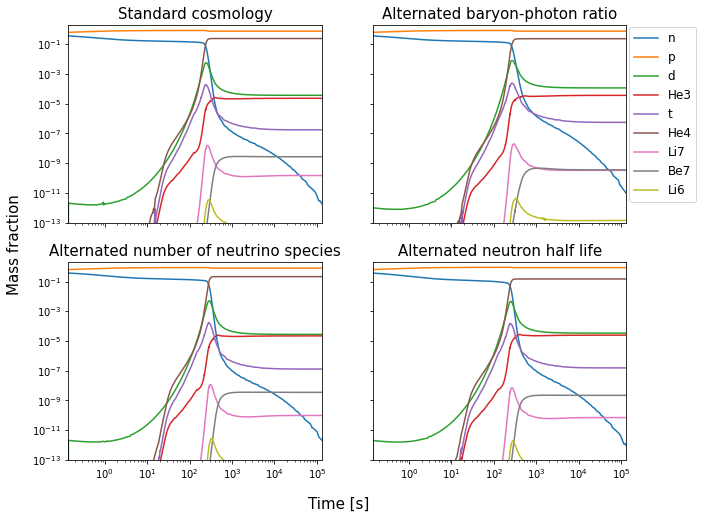

In [547]:
fig, ax = plt.subplots(2,2,sharex='all', sharey='all',figsize=(10,8))
plt.axis([t0, t1, 1e-13, 2])

for i in range(9):
    ax[0][0].loglog(ts,solution_standard.y[i],label=reactants_list[i])

for i in range(9):
    ax[0][1].loglog(ts,solution_altereta.y[i],label=reactants_list[i])
    
    
for i in range(9):
    ax[1][0].loglog(ts,solution_alternnu.y[i],label=reactants_list[i])
    
for i in range(9):
    ax[1][1].loglog(ts,solution_altertau.y[i],label=reactants_list[i])

plt.legend(bbox_to_anchor=(1.30,2.22),fontsize=12)

ax[0][0].set_title("Standard cosmology",fontsize=15)
ax[0][1].set_title("Alternated baryon-photon ratio",fontsize=15)
ax[1][0].set_title("Alternated number of neutrino species",fontsize=15)
ax[1][1].set_title("Alternated neutron half life",fontsize=15)

fig.text(0.5, 0.04, 'Time [s]', ha='center',fontsize=15)
fig.text(0.04, 0.5, 'Mass fraction', va='center', rotation='vertical',fontsize=15)
plt.savefig("abundanceplots.pdf")

In [30]:
for i in range(9):
    print(reactants_list[i], solution.y[i][-1])
    

n 1.832047353437568e-12
p 0.7608092639626474
d 3.697353600151119e-05
He3 2.3274034712603314e-05
t 1.7549822701472535e-07
He4 0.24471872065182557
Li7 1.4789074680425184e-10
Be7 2.6983555785435065e-09
Li6 4.7212915929757225e-14


## Jacobian

In [32]:
def jac(tt, y):
    Temp = y[-1]
    T_nu = y[-2]
    n_p, p_n = weak_rate(Temp) 
    rates = reaction_rate(Temp)
    eta = eta0*11/4*(2.3/T_nu)**(-3)*(Temp/2.3)**(-3)
    N = eta*n_gam(Temp) #nucleon density
    jacmat = np.zeros((len(y),len(y)))
    jacmat[0,0] = -n_p
    jacmat[0,1] = p_n
    jacmat[1,0] = n_p
    jacmat[1,1] = -p_n
    for g in range(len(reaction_list)): #i+j+k->l+m+n
        index_i = np.where(reactants_list == reaction_list[g].reac[0])[0]
        index_l = np.where(reactants_list == reaction_list[g].prod[0])[0]
        reac_num = reaction_list[g].reac_number
        if type(reaction_list[g].reac_number) == str:
            Nl = reaction_list[g].Ns[3]
            jacmat[index_i,index_i] -= reaction_list[g].fr
            jacmat[index_l,index_i] += Nl*reaction_list[g].fr
        else:
            fr = rates[reac_num]
            index_j = np.where(reactants_list == reaction_list[g].reac[1])[0]
            index_k = np.where(reactants_list == reaction_list[g].reac[2])[0]
            index_m = np.where(reactants_list == reaction_list[g].prod[1])[0]
            index_n = np.where(reactants_list == reaction_list[g].prod[2])[0]
            Ni = reaction_list[g].Ns[0]
            Nj = reaction_list[g].Ns[1]
            Nk = reaction_list[g].Ns[2]
            Nl = reaction_list[g].Ns[3]
            Nm = reaction_list[g].Ns[4]
            Nn = reaction_list[g].Ns[5]
            rr = fr*spin_list[index_i]**Ni*spin_list[index_j]**Nj*spin_list[index_k]**Nk/(spin_list[index_l]**Nl*spin_list[index_m]**Nm*spin_list[index_n]**Nn)*((mass_list[index_i]/(c**2))**Ni*(mass_list[index_j]/(c**2))**Nj*(mass_list[index_k]/(c**2))**Nk/((mass_list[index_l]/(c**2))**Nl*(mass_list[index_m]/(c**2))**Nm*(mass_list[index_n]/(c**2))**Nn))**1.5*N**(Nl+Nm+Nn-1)*((2*np.pi*Temp)**1.5/((2*np.pi*hbar)**3))**(Ni+Nj+Nk-Nl-Nm-Nn)
            rr /= Ni if Ni != 0 else 1
            rr /= Nj if Nj != 0 else 1
            rr /= Nk if Nk != 0 else 1
            rr *= Nl if Nl != 0 else 1
            rr *= Nm if Nm != 0 else 1
            rr *= Nn if Nn != 0 else 1
            fr = fr*N**(Ni+Nj+Nk-1)
            Di = fr*Ni*y[index_i]**(Ni-1)*y[index_j]**Nj*y[index_k]**Nk/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
            Dj = fr*y[index_i]**Ni*Nj*y[index_j]**(Nj-1)*y[index_k]**Nk/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
            Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
            Dl = rr*np.exp(-reaction_list[g].B/Temp)*Nl*y[index_l]**(Nl-1)*y[index_m]**Nm*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
            Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
            Dn = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*y[index_m]**Nm*Nn*y[index_n]**(Nn-1)/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
            if np.isnan(Dj)==True:
                Dj = 0
            if np.isnan(Dk)==True:
                Dk = 0
            if np.isnan(Dl)==True:
                Dl = 0
            if np.isnan(Dm)==True:
                Dm = 0
            if np.isnan(Dn)==True:
                Dn = 0
            for d, z in zip([Di,Dj,Dk],[index_i,index_j,index_k]):
                for n,ff in zip([index_i,index_j,index_k],[Ni,Nj,Nk]):
                    jacmat[n,z] -= ff*d
                for m,ff in zip([index_l,index_m,index_n],[Nl,Nj,Nk]):
                    jacmat[m,z] += ff*d
            for d, z in zip([Dl,Dm,Dn],[index_l,index_m,index_n]):
                for n,ff in zip([index_i,index_j,index_k],[Ni,Nj,Nk]):
                    jacmat[n,z] += ff*d
                for m,ff in zip([index_l,index_m,index_n],[Nl,Nj,Nk]):
                    jacmat[m,z] -= ff*d
    for i in range(len(y)):
        jacmat[-4,i] = 0
        jacmat[i,-4] = 0 
    func = bbn_eq_h(tt,y) 
    for ncol in range(len(y) - 2, len(y)): 
        del_y = np.abs(y[ncol])*1e-7 
        del_y = del_y + 1e-16*(del_y == 0)
        y[ncol] += del_y
        funch = bbn_eq_h(tt, y) 
        y[ncol] -= del_y
        for i in range(len(reactants_list)):
            jacmat[i,ncol] = (funch[i]-func[i])/del_y
        jacmat[-1,ncol] =(funch[-1]-func[-1])/del_y
        jacmat[-2,ncol] =(funch[-2]-func[-2])/del_y
    return jacmat
            
            
            
            
            

In [473]:
def numjac(tt,y):
    jacmat = np.zeros((len(y),len(y)))
    func = bbn_eq_h(tt,y)
    ncol_it = [*range(len(y))]
    ncol_it.pop(-4)
    for ncol in ncol_it:
        del_y = np.abs(y[ncol])*1e-7
        del_y = del_y + 1e-16*(del_y==0)
        y[ncol] += del_y
        funch = bbn_eq_h(tt,y)
        y[ncol] -= del_y
        for nrow in ncol_it:
            jacmat[nrow,ncol] = (funch[nrow]-func[nrow])/del_y
    return jacmat

## Solving the system with analytical jacobian

<ipython-input-32-e032dce945da>:43: RuntimeWarning: divide by zero encountered in reciprocal
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-32-e032dce945da>:43: RuntimeWarning: invalid value encountered in multiply
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-32-e032dce945da>:45: RuntimeWarning: divide by zero encountered in reciprocal
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-32-e032dce945da>:45: RuntimeWarning: invalid value encountered in multiply
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-32-e032dce945da>:46: RuntimeWarni

Text(0, 0.5, 'Y')

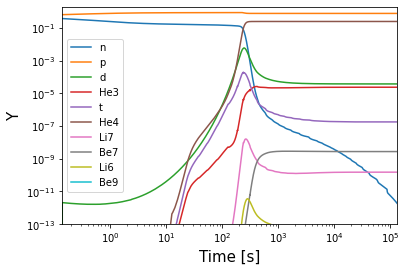

In [35]:

solution = solve_ivp(bbn_eq_h, [t0,t1], y_init,'Radau',t_eval=evalt,jac=jac,atol=1e-14)
for i in range(len(reactants_list)):
    solution.y[i] *= mass_list[i]/Dalton



ts = solution.t

for i in range(10):
    plt.loglog(ts,solution.y[i],label=reactants_list[i])
plt.axis([t0, t1, 1e-13, 2])
plt.legend()
plt.xlabel("Time [s]",fontsize=15)
plt.ylabel("Y",fontsize=15)


In [36]:
for i in range(9):
    print(reactants_list[i], solution.y[i][-1])
    

n 1.8465500741374745e-12
p 0.7608609912176975
d 3.698756619037475e-05
He3 2.3266827207719437e-05
t 1.7537464975580132e-07
He4 0.24466482635993414
Li7 1.48171673217741e-10
Be7 2.693808989997212e-09
Li6 4.721662889713226e-14


0.24674445167190281

0.24697909999999998

In [125]:
ra = [[(88-7*np.sqrt(6))/360,    (296-169*np.sqrt(6))/1800,  (-2+3*np.sqrt(6))/225],
    [(296+169*np.sqrt(6))/1800, (88+7*np.sqrt(6))/3600,     (-2-3*np.sqrt(6))/225],
    [(16-np.sqrt(6))/36,           (16+np.sqrt(6))/36,         1/9]]

rb = [(16-np.sqrt(6))/36, (16+np.sqrt(6))/36, 1/9]
rc = [(4-np.sqrt(6))/10,  (4+np.sqrt(6))/10, 1]


def radau5(func,y0,ts):
    n = y0.shape[0]
    y = np.zeros((len(ts),n))
    y[0] = y0
    f0 = func(ts[0],y[0])
    h0 = ts[1]-ts[0]
    zs = np.concatenate([h0*f0]*3)
    n_ts = 0
    for i in range(len(y))[:-1]:
        n_ts += 1
        print(n_ts)
        h = ts[i+1]-ts[i]
        def G(z):
            z1,z2,z3 = np.split(z,[n,2*n])
            F1 = func(ts[i]+rc[0]*h,y[i]+z1)
            F2 = func(ts[i]+rc[1]*h,y[i]+z2)
            F3 = func(ts[i]+rc[2]*h,y[i]+z3)
            G1 = z1-h*(ra[0][0]*F1+ra[0][1]*F2+ra[0][2]*F3)
            G2 = z2-h*(ra[1][0]*F1+ra[1][1]*F2+ra[1][2]*F3)
            G3 = z3-h*(ra[2][0]*F1+ra[2][1]*F2+ra[2][2]*F3)
            return np.concatenate([G1,G2,G3]) 
        root = fsolve(G,zs)
        zs = root
        y[i+1] = y[i] + root[2*n:]
    return ts,y

In [472]:
%%timeit
J_analytical = jac(t0,y_init)

<ipython-input-471-e032dce945da>:43: RuntimeWarning: divide by zero encountered in reciprocal
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-471-e032dce945da>:43: RuntimeWarning: invalid value encountered in multiply
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-471-e032dce945da>:45: RuntimeWarning: divide by zero encountered in reciprocal
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-471-e032dce945da>:45: RuntimeWarning: invalid value encountered in multiply
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-471-e032dce945da>:46: Runtime

38.6 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [237]:
%%timeit
J=0
for n in range(len(y_init) + 1):
    J += bbn_eq_h(t0,y_init)

191 ms ± 4.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [288]:
%%timeit 
J_num = numjac(t0,y_init)

190 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [595]:

J_analytical = jac(ts[-50],solution.y[:,-50])
J_num = numjac(ts[-50],solution.y[:,-50])
J_dif = np.abs(J_analytical-J_num)



<ipython-input-471-e032dce945da>:43: RuntimeWarning: divide by zero encountered in reciprocal
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-471-e032dce945da>:43: RuntimeWarning: invalid value encountered in multiply
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-471-e032dce945da>:45: RuntimeWarning: divide by zero encountered in reciprocal
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-471-e032dce945da>:45: RuntimeWarning: invalid value encountered in multiply
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-471-e032dce945da>:46: Runtime

In [596]:
import matplotlib.pyplot as plt
import numpy as np



x = [] #col
y = [] #row
for i in range(len(y_init)):
    for j in range(len(y_init)):
        y.append(i)

        

for i in range(len(y_init)):
    for j in range(len(y_init)):
        x.append(j)



## Difference between numerical and analytical jacobian

<ipython-input-602-c443d569a7af>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(J_dif), interpolation='none')


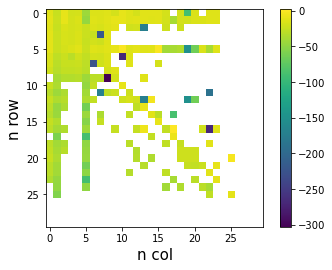

In [602]:
plt.imshow(np.log10(J_dif), interpolation='none')
plt.colorbar()
plt.ylabel("n row",fontsize=15)
plt.xlabel("n col",fontsize=15)
plt.savefig("Jdif.pdf")
plt.show()


## Sparse matrix representation

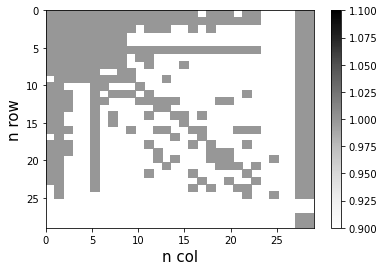

[[True True True True True True True True True True True True True True
  True True True 0 True True True 0 True True 0 0 0 0 True True]
 [True True True True True True True True True True True True True True
  True True True True True True True True True True 0 0 0 0 True True]
 [True True True True True True True True True True 0 True True True 0 0
  True 0 True 0 0 0 0 0 0 0 0 0 True True]
 [True True True True True True True True True 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 True True]
 [True True True True True True True True True 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 True True]
 [True True True True True True True True True True True True True True
  True True True True True True True True True True 0 0 0 0 True True]
 [True True True True True True True True True 0 True True 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 True True]
 [True True True True True True True True True 0 0 True 0 0 0 True 0 0 0
  0 0 0 0 0 0 0 0 0 True True]
 [True True True True True True 0 0 True True 0 0 0 0 0 0

In [589]:
x_hist = [] #ncol

y_hist = [] #nrow

J_an_spars = np.zeros((len(y_init),len(y_init)),dtype='object')

for i in range(len(y_init)):
    for j in range(len(y_init)):
        if J_analytical[i,j] != 0:
            J_an_spars[i,j] = True
        
        
for i in range(len(J_analytical.ravel())):
    if J_analytical.ravel()[i] != 0:
        x_hist.append(x[i])
        y_hist.append(y[i])
    
    
plt.hist2d(x_hist, y_hist, bins=(30, 30), cmin=1, cmap=plt.cm.Greys)
plt.colorbar()
plt.xlabel("n col",fontsize=15)
plt.ylabel("n row",fontsize=15)
plt.ylim(29,0)
plt.savefig("sparsity.pdf")
plt.show()



In [590]:
sparsity = (len(x)-len(x_hist))/len(x)
print(sparsity)

0.6511111111111111


In [457]:
n_fev = 0

solution = solve_ivp(bbn_eq_h, [t0,t1], y_init,'Radau',t_eval=evalt,jac=jac,atol=1e-13)

print(solution)
print(n_fev)

<ipython-input-414-f1850767b9b7>:43: RuntimeWarning: divide by zero encountered in reciprocal
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-414-f1850767b9b7>:43: RuntimeWarning: invalid value encountered in multiply
  Dk = fr*y[index_i]**Ni*y[index_j]**Nj*Nk*y[index_k]**(Nk-1)/(np.math.factorial(Ni)*np.math.factorial(Nj)*np.math.factorial(Nk))
<ipython-input-414-f1850767b9b7>:45: RuntimeWarning: divide by zero encountered in reciprocal
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-414-f1850767b9b7>:45: RuntimeWarning: invalid value encountered in multiply
  Dm = rr*np.exp(-reaction_list[g].B/Temp)*y[index_l]**Nl*Nm*y[index_m]**(Nm-1)*y[index_n]**Nn/(np.math.factorial(Nl)*np.math.factorial(Nm)*np.math.factorial(Nn))
<ipython-input-414-f1850767b9b7>:46: Runtime

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 5151
     njev: 167
      nlu: 1132
      sol: None
   status: 0
  success: True
        t: array([1.39856984e-01, 1.39876231e-01, 1.39895480e-01, ...,
       1.32365153e+05, 1.32383369e+05, 1.32401587e+05])
 t_events: None
        y: array([[3.66243809e-01, 3.66234025e-01, 3.66224244e-01, ...,
        1.82833363e-12, 1.82724928e-12, 1.82616576e-12],
       [6.33756191e-01, 6.33765975e-01, 6.33775756e-01, ...,
        7.55297046e-01, 7.55297046e-01, 7.55297046e-01],
       [0.00000000e+00, 1.00877299e-12, 1.00872406e-12, ...,
        1.83634391e-05, 1.83634389e-05, 1.83634388e-05],
       ...,
       [2.05466300e-05, 2.05466204e-05, 2.05466107e-05, ...,
        7.49706848e-06, 7.49706848e-06, 7.49706848e-06],
       [2.30000000e+00, 2.29984090e+00, 2.29968181e+00, ...,
        2.25193321e-03, 2.25177827e-03, 2.25162334e-03],
       [2.30000000e+00, 2.29984126e+00, 2.29968253e+00, ...,
        3

In [560]:
5652-5151

501

In [456]:
n_fev = 0


solution = solve_ivp(bbn_eq_h, [t0,t1], y_init,'Radau',t_eval=evalt,atol=1e-13)

print(solution)
print(n_fev)


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 5397
     njev: 156
      nlu: 1202
      sol: None
   status: 0
  success: True
        t: array([1.39856984e-01, 1.39876231e-01, 1.39895480e-01, ...,
       1.32365153e+05, 1.32383369e+05, 1.32401587e+05])
 t_events: None
        y: array([[3.66243809e-01, 3.66234025e-01, 3.66224244e-01, ...,
        1.82039287e-12, 1.81954530e-12, 1.81870130e-12],
       [6.33756191e-01, 6.33765975e-01, 6.33775756e-01, ...,
        7.55315107e-01, 7.55315107e-01, 7.55315107e-01],
       [0.00000000e+00, 1.00877299e-12, 1.00872406e-12, ...,
        1.83721015e-05, 1.83721014e-05, 1.83721012e-05],
       ...,
       [2.05466300e-05, 2.05466204e-05, 2.05466107e-05, ...,
        7.49687472e-06, 7.49687472e-06, 7.49687472e-06],
       [2.30000000e+00, 2.29984090e+00, 2.29968181e+00, ...,
        2.25192530e-03, 2.25177036e-03, 2.25161543e-03],
       [2.30000000e+00, 2.29984126e+00, 2.29968253e+00, ...,
        3